# Title

## Preliminary

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from deepdiff import DeepDiff

from HANKStickyModel import HANKStickyModelClass

# Overview
1. Model IRFs + Model decomposition
2. Fiscal Multipliers
3. Effect of sticky information

In [2]:
model = HANKStickyModelClass(name='baseline_2602', par = {'beta_mean': 0.9988,
                                                         'sigma_e': 0.36})
# model.load()
model.find_ss(do_print=True)

find beta for market clearing
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [14.4 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [9.2 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [8.7 secs]
 [beta, sigma_e] = [  0.998800014883,   0.360000000000] -> [ss.clearing_Y =   0.000231505769, ss.clearing_MPC =  -0.003892680925] [8.7 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000005364] -> [ss.clearing_Y =   0.000231563740, ss.clearing_MPC =  -0.003893593267] [8.8 secs]
 [beta, sigma_e] = [  0.998870226555,   0.359526595375] -> [ss.clearing_Y =  -0.000003386733, ss.clearing_MPC =   0.000022871562] [8.9 secs]
 [beta, sigma_e] = [  0.998870675861,   0.359471319250] -> [ss.clearing_Y =   0.000000061321, ss.clearing_MPC =   0.0000011

In [3]:
# model.save()

In [4]:
model_sticky = model.copy()
model_sticky.par.inattention = 0.935

theta_list = [0.0, 0.3, 0.6, 0.935, 1.0]

ss = model.ss
par = model.par

relevant_settings = {
    'beta': 'beta_mean',
    'T': 'T',
    'MPC target': 'MPC_target'
}
for key, value in relevant_settings.items():
    print(f'{key}: {par.__dict__[value]}')

beta: 0.9988706012174102
T: 400
MPC target: 0.525


# HH jacs

In [5]:
model._compute_jac_hh(do_print=True)

one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for eg_transfer     in 6.7 secs
curly_Y and curly_D calculated for ra              in 6.6 secs
curly_Y and curly_D calculated for rl              in 6.6 secs
curly_Y and curly_D calculated for tau             in 6.7 secs
curly_Y and curly_D calculated for wN              in 6.6 secs
curly_E calculated in 3.6 secs
builiding blocks combined in 2.7 secs
household Jacobian computed in 39.4 secs


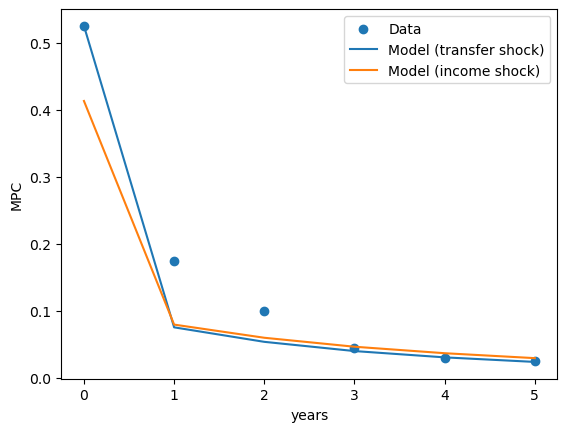

In [16]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]
MPCs_model = [
    np.sum([model.jac_hh[('C_hh', 'eg_transfer')][(t * 4 + i), 0] / (1 + ss.r) ** (t * 4 + i) for i in range(4)])
    for t in [0, 1, 2, 3, 4, 5]
]
MPCs_model_wN = [
    np.sum([model.jac_hh[('C_hh', 'wN')][(t * 4 + i), 0] / (1 - ss.tau) / (1 + ss.r) ** (t * 4 + i) for i in range(4)])
    for t in [0, 1, 2, 3, 4, 5]
]

# MPCs_simple_model = [0.5249999999992161,
#  0.07790951422808526,
#  0.05598251531527659,
#  0.041474221608445314,
#  0.031426975112043745,
#  0.024217412917137773]

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
ax.plot(np.arange(6), MPCs_model, label='Model (transfer shock)')
ax.plot(np.arange(6), MPCs_model_wN, label='Model (income shock)')
# ax.plot(np.arange(6), MPCs_simple_model, label='Simple model (transfer shock)')
ax.set_ylabel("MPC")
ax.set_xlabel('years')
ax.legend()

# Functions

In [17]:
def calc_FMP(IRF, ss_r, cum_FMP_max_T=None):
    """Calculate fiscal multiplier"""

    assert IRF['eg'].any() or IRF['eg_transfer'].any(), 'No fiscal policy shocks specified'
    assert IRF['G'][0] != 0.0, 't=0, G == 0 -> divide error in fiscal multiplier'

    dY = np.array([(1 + ss_r) ** (-t) * IRF['Y'][t] for t in range(cum_FMP_max_T + 1)])
    dG = np.array([(1 + ss_r) ** (-t) * IRF['G'][t] for t in range(cum_FMP_max_T + 1)])

    fmp_cum = dY[:cum_FMP_max_T + 1].sum() / dG[:cum_FMP_max_T + 1].sum()

    return fmp_cum

In [18]:
def plot_FMPs(IRF_thetas):
    max_T = 20

    ncols = 3
    nrows = 1
    fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)

    ax = fig.add_subplot(nrows,ncols,1)

    for theta in theta_list:
        fmps = [calc_FMP(IRF_thetas[theta], ss.r, t) for t in range(max_T)]
        ax.plot(np.arange(max_T), fmps, label=f'$\\theta = {theta}$')
    ax.set_xlabel('t (in quarters)')
    ax.set_ylabel('cumulative FMP')
    ax.legend()

    ax = fig.add_subplot(nrows,ncols,2)
    fmps_no_sticky = [calc_FMP(IRF_thetas[0.0], ss.r, t) for t in range(max_T)]
    for theta in theta_list:
        fmps = [calc_FMP(IRF_thetas[theta], ss.r, t) for t in range(max_T)]
        fmps_dev = np.array(fmps) - np.array(fmps_no_sticky)
        ax.plot(np.arange(max_T), fmps_dev, label=f'$\\theta = {theta}$')
    ax.set_xlabel('t (in quarters)')
    ax.set_ylabel('abs diff to FMP(theta=0)')
    ax.legend()

    # ax = fig.add_subplot(nrows,ncols,3)
    # fmps_no_sticky = [calc_FMP(IRF_thetas[0.0], ss.r, t) for t in range(max_T)]
    # for theta in theta_list:
    #     fmps = [calc_FMP(IRF_thetas[theta], ss.r, t) for t in range(max_T)]
    #     fmps_perc_dev = (np.array(fmps) / np.array(fmps_no_sticky) - 1) * 100
    #     ax.plot(np.arange(max_T), fmps_perc_dev, label=f'$\\theta = {theta}$')
    # ax.set_xlabel('t (in quarters)')
    # ax.set_ylabel('perc diff to FMP(theta=0)')
    # ax.legend()

    ax = fig.add_subplot(nrows,ncols,3)
    for max_T in [0,3,7,11,15,19]:
        fmps = [calc_FMP(IRF_thetas[theta], ss.r, max_T) for theta in theta_list]
        ax.plot(theta_list, fmps, label = f'T={max_T}')
    ax.set_xlabel('theta')
    ax.set_ylabel('cumulative FMP')
    ax.legend()

In [19]:
def find_IRFs(model, model_sticky, shocks):
    # calc IRFs
    print('find IRFs (no sticky)')
    model.find_IRFs(shocks=shocks)
    print('find IRFs (sticky)')
    model_sticky.find_IRFs(shocks=shocks)

def calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg']):
    # make sure only inattention parameter is different
    assert (len(diff := DeepDiff(model.par.__dict__, model_sticky.par.__dict__)['values_changed'].keys())) == 1, diff

    print(f'Fiscal policy settings:')
    print(f'phi_G = {model.par.phi_G}')
    print(f'phi_tau = {model.par.phi_tau}')
    print(f'phi_pi = {model.par.phi_pi}')
    print(f'rho_m = {model.par.rho_m}')
    print('')

    print(f'shock settings:')
    for s in shocks:
        jump_name = 'jump_'+s
        rho_name = 'rho_'+s
        print(f'shock: {s} -> jump = {model.par.__dict__[jump_name]}, rho = {model.par.__dict__[rho_name]}')
    print('')

    # compute jacs: model without sticky information
    print('Compute Jacobians (no sticky) ')
    assert model.par.inattention == 0.0
    model._compute_jac(inputs='unknowns')
    model._compute_jac(inputs='shocks')
    # model.compute_jacs(do_print=False)
    # compute jacs: model with sticky information
    print('Compute Jacobians (sticky) ')
    model_sticky.par.inattention = inattention_baseline
    model_sticky.jac_hh = deepcopy(model.jac_hh)
    model_sticky.jac_hh = model_sticky._compute_sticky_jacs_hh(model_sticky.jac_hh)
    model_sticky._compute_jac(inputs='unknowns')
    model_sticky._compute_jac(inputs='shocks')
    # model_sticky.compute_jacs(do_print=False)

    find_IRFs(model, model_sticky, shocks)


In [20]:
def show_only_IRFs(model, IRFs, labels, varnames,
                   abs_diff=None, lvl_value=None, facs=None, pows=None,
                   do_shocks=True, do_targets=True,
                   ncols=4, T_max=None, filename=None):

    abs_diff = [] if abs_diff is None else abs_diff
    lvl_value = [] if lvl_value is None else lvl_value
    facs = {} if facs is None else facs
    pows = {} if pows is None else pows

    par = model.par
    if T_max is None: T_max = par.T

    # full_list
    full_list = []
    if do_shocks: full_list.append(('shocks', [x for x in model.shocks]))
    full_list.append(('varnames', varnames))
    if do_targets: full_list.append(('tagets', [x for x in model.targets]))

    # default fac = 1.0
    for (typename, varnames) in full_list:
        for varname in varnames:
            if not varname in facs: facs[varname] = 1.0
            if not varname in pows: pows[varname] = 1.0

    # figures
    do_legend = any([not x is None for x in labels])
    for (typename, varnames) in full_list:

        if do_shocks or do_targets: print(f'### {typename} ###')

        num = len(varnames)
        nrows = num // ncols + 1
        if num % ncols == 0: nrows -= 1

        fig = plt.figure(figsize=(6 * ncols, 4 * nrows), dpi=100)
        for i, varname in enumerate(varnames):

            ax = fig.add_subplot(nrows, ncols, i + 1)
            title = varname
            if not np.isclose(pows[varname], 1.0): title += (' (ann.)')
            ax.set_title(title, fontsize=14)

            for label, IRF_ in zip(labels, IRFs):

                # pathvalue = model_.path.__dict__[varname][:,0]
                IRFvalue = IRF_[varname]

                if not np.isnan(getattr(model.ss, varname)):

                    ssvalue = model.ss.__dict__[varname]
                    IRFvalue = IRFvalue + ssvalue

                    if varname in lvl_value or varname in model.targets:

                        if np.isclose(ssvalue, 1.0):
                            IRFvalue = facs[varname] * IRFvalue ** pows[varname]
                        else:
                            IRFvalue = facs[varname] * ((1 + IRFvalue) ** pows[varname] - 1)

                        ax.plot(np.arange(T_max), IRFvalue[:T_max], label=label)

                        if not np.isclose(facs[varname], 1.0):
                            ax.set_ylabel(fr'{facs[varname]:.0f} x level')
                        else:
                            ax.set_ylabel('')

                    elif varname in abs_diff:

                        if np.isclose(ssvalue, 1.0):
                            ssvalue = facs[varname] * ssvalue ** pows[varname]
                            IRFvalue = facs[varname] * IRFvalue ** pows[varname]
                        else:
                            ssvalue = facs[varname] * ((1 + ssvalue) ** pows[varname] - 1)
                            IRFvalue = facs[varname] * ((1 + IRFvalue) ** pows[varname] - 1)

                        ax.plot(np.arange(T_max), IRFvalue[:T_max] - ssvalue, label=label)

                        if varname in facs:
                            ax.set_ylabel(fr'{facs[varname]:.0f} x abs. diff. to of s.s.')
                        else:
                            ax.set_ylabel('abs. diff. to of s.s.')

                    else:

                        ax.plot(np.arange(T_max), 100 * (IRFvalue[:T_max] / ssvalue - 1), label=label)

                        ax.set_ylabel('% diff. to s.s.')

                else:

                    ax.plot(np.arange(T_max), IRFvalue[:T_max], label=label)

            if (len(labels) > 1) and i == 0: ax.legend(frameon=True)

        fig.tight_layout(pad=3.0)
        plt.show()
        print('')

        # save
        if not filename is None: fig.savefig(f'{filename}_{typename}.pdf')

# Tax financed fiscal shock

In [21]:
model.par.phi_G = model_sticky.par.phi_G = 0.0
model.par.phi_pi = model_sticky.par.phi_pi = 0.0
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government_constant_B',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']


model.par.rho_eg = model_sticky.par.rho_eg = 0.85
model.par.jump_eg = model_sticky.par.jump_eg = 0.01
model.par.jump_eg_transfer = model_sticky.par.jump_eg_transfer = 0.0
model.par.jump_em = model_sticky.par.jump_em = 0.0
delta_G = model.par.jump_eg * model.par.rho_eg ** np.arange(model.par.T)
print(f'Shock with parameters jump = {model.par.jump_eg}, rho = {model.par.rho_eg} leads to a total spending increase of {delta_G.sum()*100:.2f}%')

Shock with parameters jump = 0.01, rho = 0.85 leads to a total spending increase of 6.67%


In [13]:
calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg'])

Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 0.0
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)


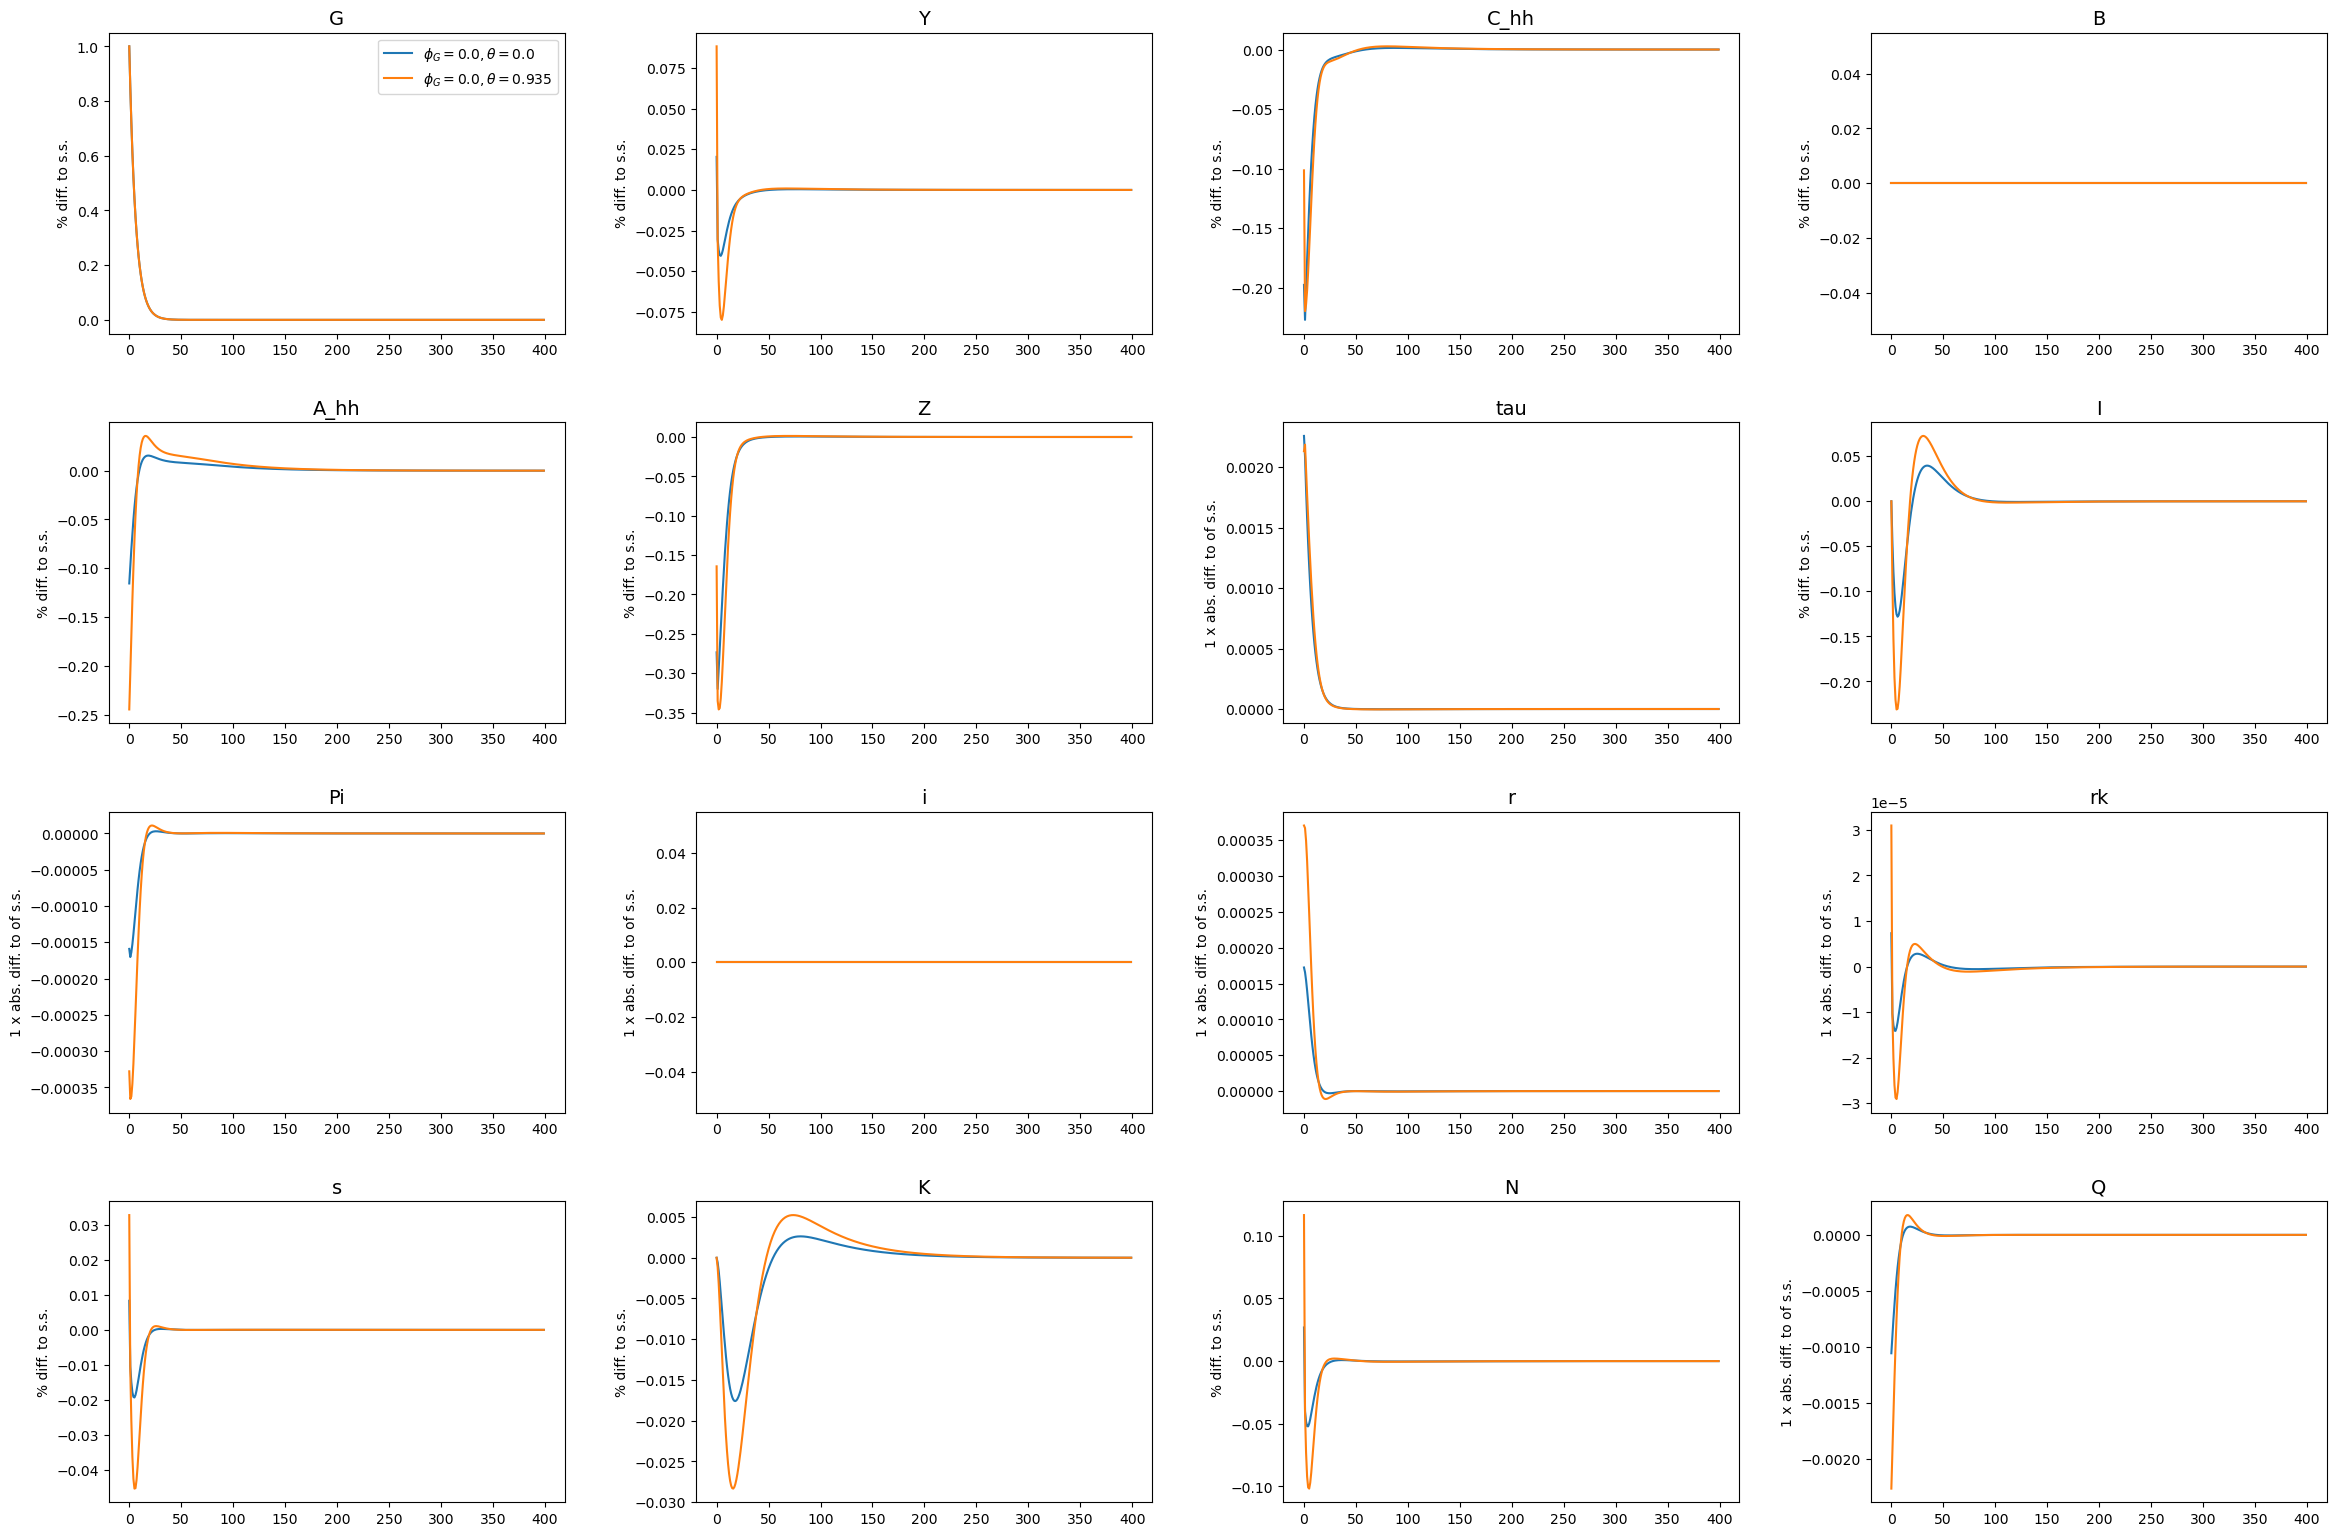

In [14]:
models = [model, model_sticky]
labels = [f'$\phi_G = {m.par.phi_G}, \\theta = {m.par.inattention}$' for m in models]
paths_short = ['G', 'Y', 'C_hh', 'B', 'A_hh', 'Z', 'tau', 'I','Pi','i','r','rk','s','K','N','Q']
lvl_value = ['eg', 'em']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra','rl','Q']
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False)


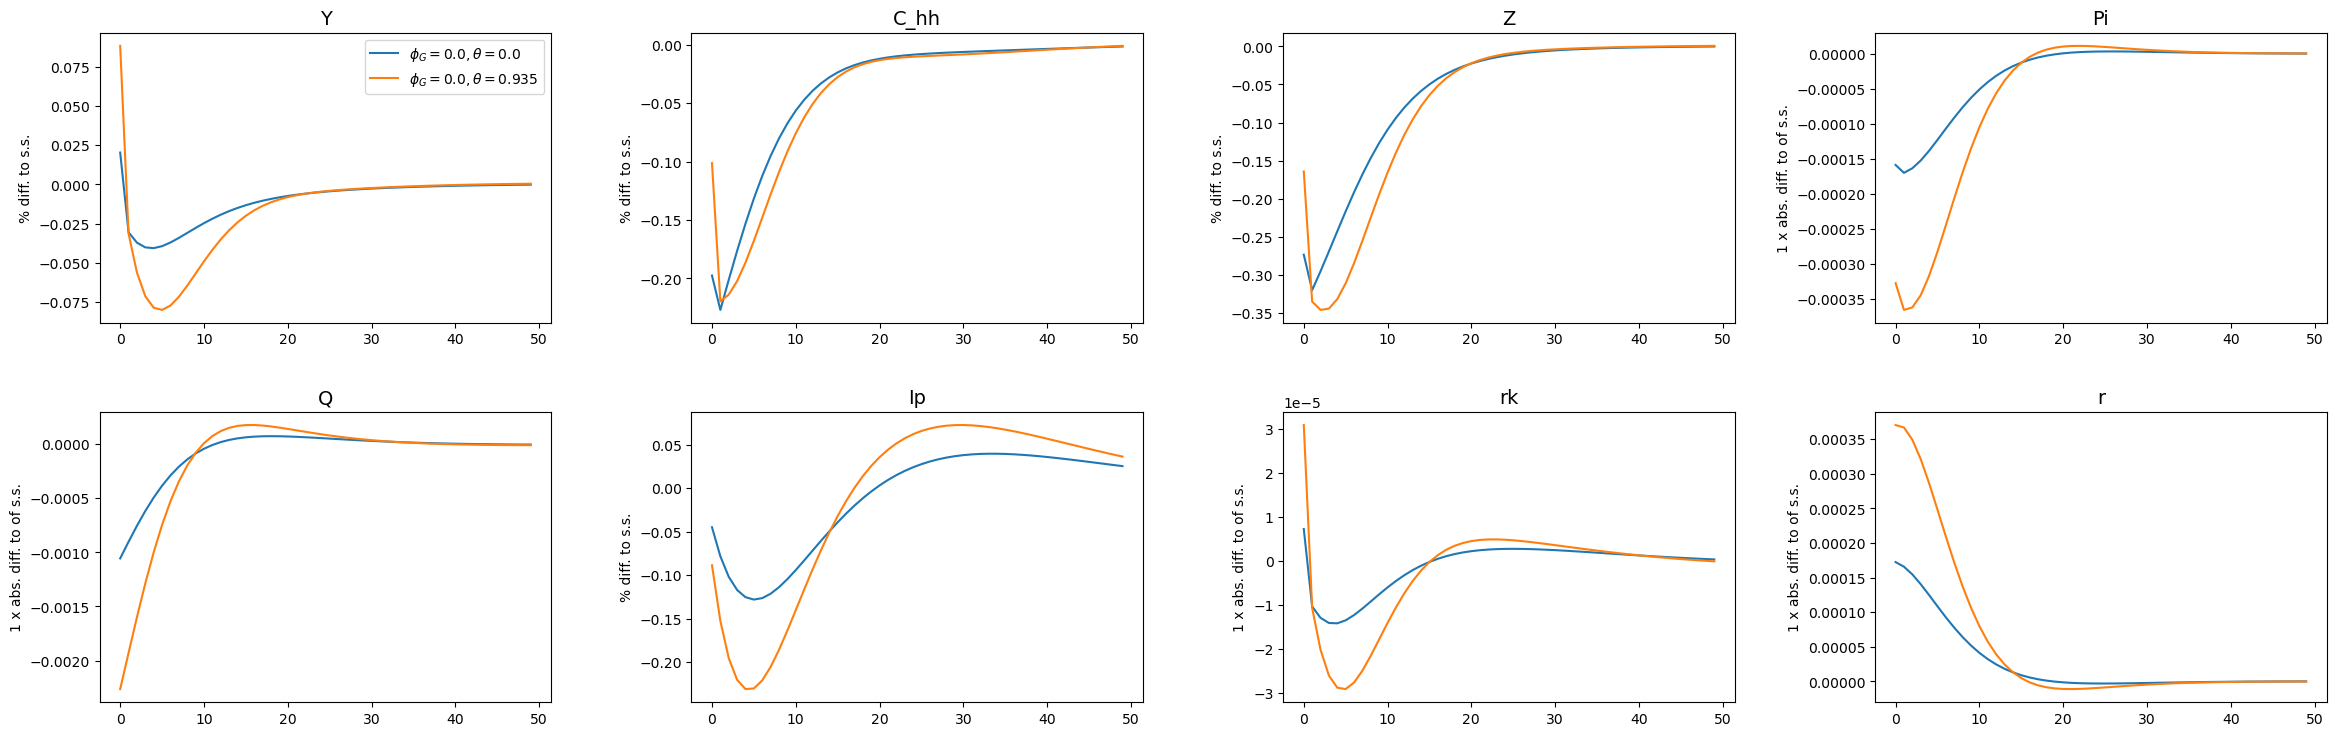

In [15]:
paths_essential = ['Y','C_hh','Z','Pi','Q','Ip','rk','r']
model.compare_IRFs(models, labels, paths_essential, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False, T_max=50)

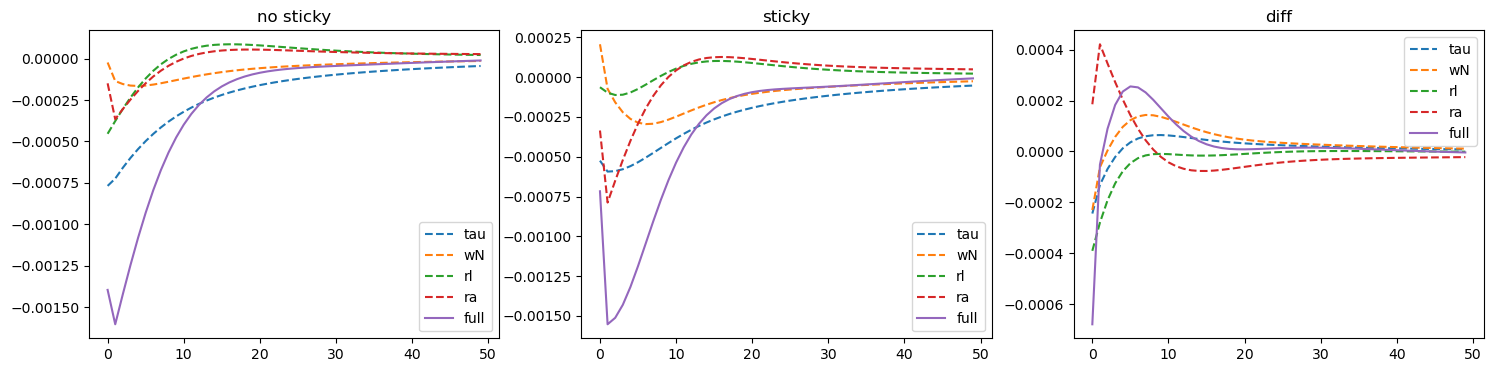

In [16]:
def plot_decomp_C(ax, jac_hh, IRF, T_max=model.IRF['Y'].shape[0], return_dC = True):
    dC_tau = jac_hh[('C_hh', 'tau')] @ IRF['tau']
    dC_wN = jac_hh[('C_hh', 'wN')] @ IRF['wN']
    dC_rl = jac_hh[('C_hh', 'rl')] @ IRF['rl']
    dC_ra = jac_hh[('C_hh', 'ra')] @ IRF['ra']
    dC_full = IRF['C_hh']
    assert np.isclose(dC_tau + dC_wN + dC_rl + dC_ra, dC_full).all()
    ax.plot(np.arange(T_max), dC_tau[:T_max], label='tau', ls='--')
    ax.plot(np.arange(T_max), dC_wN[:T_max], label='wN', ls='--')
    ax.plot(np.arange(T_max), dC_rl[:T_max], label='rl', ls='--')
    ax.plot(np.arange(T_max), dC_ra[:T_max], label='ra', ls='--')
    ax.plot(np.arange(T_max), dC_full[:T_max], label='full')
    # ax.plot(np.arange(T_max), dC_full[:T_max] - (dC_Z[:T_max] + dC_rl[:T_max] + dC_ra[:T_max]), label='Diff')
    ax.legend()

    if return_dC:
        return dC_full, dC_tau, dC_wN, dC_rl, dC_ra

T_max = 50
ncols = 3
nrows = 1
fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)
ax1 = fig.add_subplot(nrows,ncols,1)
ax1.set_title('no sticky')
dC_full, dC_tau, dC_wN, dC_rl, dC_ra = plot_decomp_C(ax1, model.jac_hh, model.IRF, T_max=T_max)

ax2 = fig.add_subplot(nrows,ncols,2)
ax2.set_title('sticky')
dC_full_sticky, dC_tau_sticky, dC_wN_sticky, dC_rl_sticky, dC_ra_sticky = plot_decomp_C(ax2, model_sticky.jac_hh, model_sticky.IRF, T_max=T_max)

ax3 = fig.add_subplot(nrows,ncols,3)
ax3.set_title('diff')
ax3.plot(np.arange(T_max), diff_tau := dC_tau[:T_max]-dC_tau_sticky[:T_max], label='tau', ls='--')
ax3.plot(np.arange(T_max), diff_wN := dC_wN[:T_max]-dC_wN_sticky[:T_max], label='wN', ls='--')
ax3.plot(np.arange(T_max), diff_rl := dC_rl[:T_max]-dC_rl_sticky[:T_max], label='rl', ls='--')
ax3.plot(np.arange(T_max), diff_ra := dC_ra[:T_max]-dC_ra_sticky[:T_max], label='ra', ls='--')
ax3.plot(np.arange(T_max), diff_full := dC_full[:T_max]-dC_full_sticky[:T_max], label='full')
assert np.isclose(diff_full, diff_tau+diff_wN+diff_rl+diff_ra).all()
ax3.legend()
# jac_hh_diff = {d:model.jac_hh[d]-model_sticky.jac_hh[d] for d,k in model.jac_hh.items()}
# IRF_diff = deepcopy(model_sticky.IRF)
# IRF_diff['C_hh'] = model.IRF['C_hh'] - model_sticky.IRF['C_hh']
# plot_decomp_C(ax3, jac_hh_diff, IRF_diff, T_max=T_max)

# fig = plt.figure(figsize=(6*1,4*1),dpi=100)
# ax = fig.add_subplot(1,1,1)
#
# ax.plot(np.arange(T_max), dC_full[:T_max], label='no sticky')
# ax.plot(np.arange(T_max), dC_full_sticky[:T_max], label='sticky')
# ax.plot(np.arange(T_max), diff_tau, label='tau', ls='--')
# ax.plot(np.arange(T_max), diff_wN, label='wN', ls='--')
# ax.plot(np.arange(T_max), diff_rl, label='rl', ls='--')
# ax.plot(np.arange(T_max), diff_ra, label='ra', ls='--')

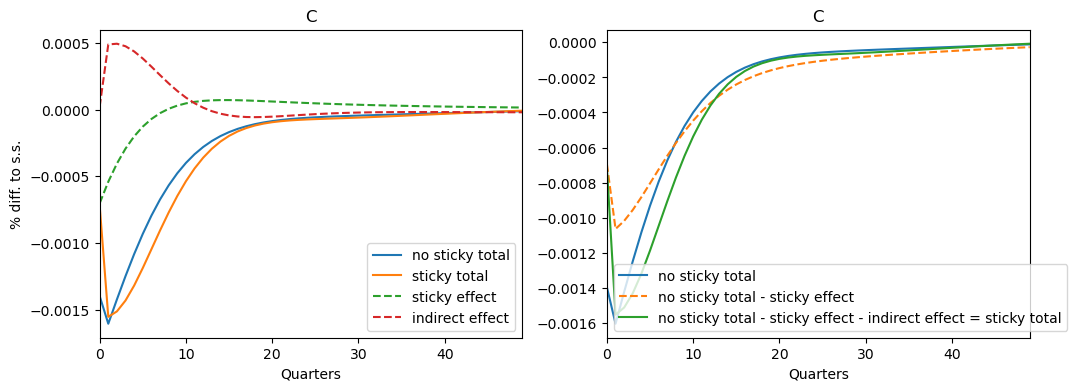

In [17]:
jac_hh_sticky = model_sticky.jac_hh
jac_hh= model.jac_hh
IRF_sticky = model_sticky.IRF
IRF = model.IRF

keys = [('C_hh', 'tau'), ('C_hh', 'wN'), ('C_hh', 'rl'), ('C_hh', 'ra')]
dC_sticky = np.zeros_like(IRF['C_hh'])
dC_sticky = np.array([(jac_hh[key] - jac_hh_sticky[key]) @ IRF[key[1]] for key in keys]).sum(axis=0)
dC_indirect = np.array([jac_hh_sticky[key] @ (IRF[key[1]] - IRF_sticky[key[1]]) for key in keys]).sum(axis=0)

assert np.isclose(IRF['C_hh'] - (IRF_sticky['C_hh'] + dC_sticky + dC_indirect), 0.0).all()

ncols = 2
nrows = 1
fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)
ax1 = fig.add_subplot(nrows,ncols,1)
ax1.set_title('C')
ax1.set_xlabel('Quarters')
ax1.set_ylabel('% diff. to s.s.')
ax1.set_xlim(0,T_max-1)

ax1.plot(np.arange(T_max), IRF['C_hh'][:T_max], label='no sticky total')
ax1.plot(np.arange(T_max), IRF_sticky['C_hh'][:T_max], label='sticky total')
ax1.plot(np.arange(T_max), dC_sticky[:T_max], label='sticky effect', ls='--')
ax1.plot(np.arange(T_max), dC_indirect[:T_max], label='indirect effect', ls='--')
ax1.legend()

ax2 = fig.add_subplot(nrows,ncols,2)
ax2.set_title('C')
ax2.set_xlabel('Quarters')
# ax2.set_ylabel('% diff. to s.s.')
ax2.set_xlim(0,T_max-1)

ax2.plot(np.arange(T_max), IRF['C_hh'][:T_max], label='no sticky total')
ax2.plot(np.arange(T_max), IRF['C_hh'][:T_max] - dC_sticky[:T_max], label='no sticky total - sticky effect', ls='--')
ax2.plot(np.arange(T_max), IRF['C_hh'][:T_max] - dC_sticky[:T_max] - dC_indirect[:T_max], label='no sticky total - sticky effect - indirect effect = sticky total')
# ax2.plot(np.arange(T_max), IRF_sticky['C_hh'][:T_max], label='sticky total')
ax2.legend()



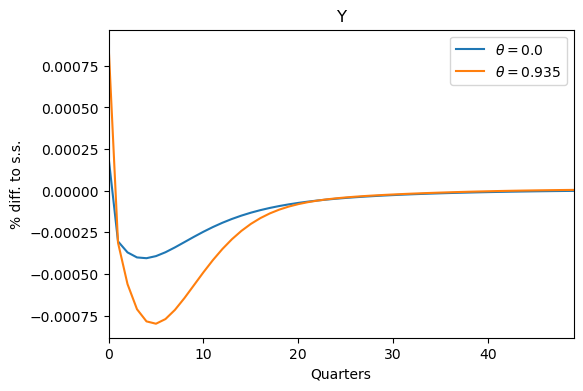

In [18]:
# summary plot
models = [model, model_sticky]
IRFs = [model.IRF, model_sticky.IRF]

T_max = 50

ncols = 1
nrows  = 1

fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)
ax1 = fig.add_subplot(nrows,ncols,1)
ax1.set_title('Y')
ax1.set_ylabel('% diff. to s.s.')
ax1.set_xlabel('Quarters')
ax1.set_xlim(0,T_max-1)

for m in models:
    ax1.plot(np.arange(T_max), m.IRF['Y'][:T_max]/ss.Y, label=f'$\\theta = {m.par.inattention}$')
ax1.legend()



# plot 2 -> Consumption

# plot 3 -> spending decomposition



## Theta variation

In [19]:
jacs_hh_thetas = {}
no_sticky_jacs = deepcopy(model.jac_hh)
for theta in theta_list:
    model_sticky.par.inattention = theta
    jacs_hh_thetas[theta] = model_sticky._compute_sticky_jacs_hh(no_sticky_jacs)


In [20]:
IRF_thetas = {}
print(f'calc IRFs for phi_G = {model.par.phi_G} and ...')
for theta in theta_list:
    print(f'theta: {theta}')
    model_temp = deepcopy(model)
    model_temp.par.inattention = theta
    model_temp.jac_hh = jacs_hh_thetas[theta]
    model_temp._compute_jac(inputs='unknowns',do_print=False)
    model_temp._compute_jac(inputs='shocks',do_print=False)
    model_temp.find_IRFs(shocks=['eg'])
    IRF_thetas[theta] = deepcopy(model_temp.IRF)

calc IRFs for phi_G = 0.0 and ...
theta: 0.0
theta: 0.3
theta: 0.6
theta: 0.935
theta: 1.0


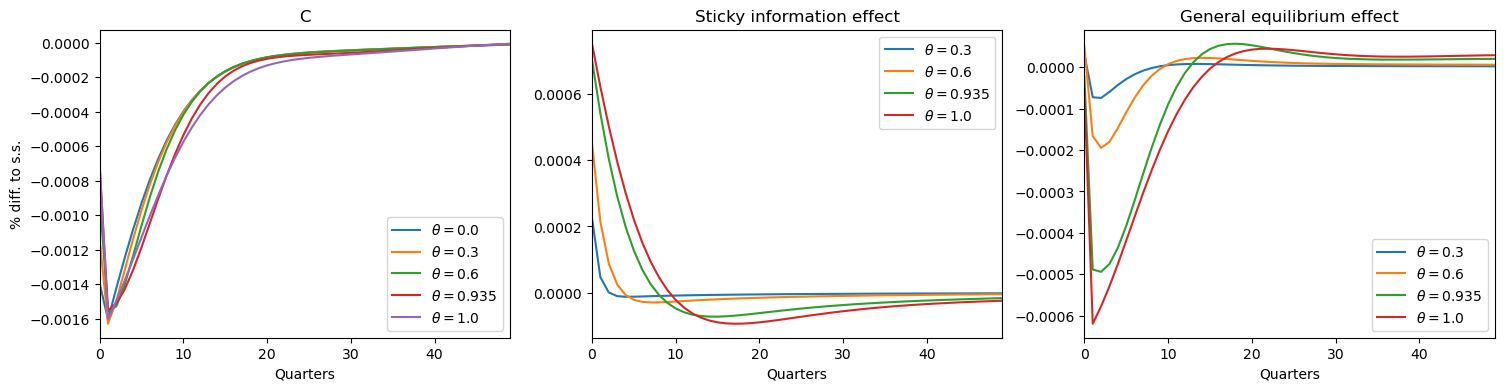

In [21]:
ncols = 3
nrows = 1
fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)

T_max = 50

ax1 = fig.add_subplot(nrows,ncols,1)
ax1.set_title('C')
ax1.set_xlabel('Quarters')
ax1.set_ylabel('% diff. to s.s.')
ax1.set_xlim(0,T_max-1)

for theta in theta_list:
    ax1.plot(np.arange(T_max), IRF_thetas[theta]['C_hh'][:T_max], label=f'$\\theta = {theta}$')
ax1.legend()

ax2 = fig.add_subplot(nrows,ncols,2)
ax2.set_title('Sticky information effect')
ax2.set_xlabel('Quarters')
# ax2.set_ylabel('% diff. to C s.s.')
ax2.set_xlim(0,T_max-1)

ax3 = fig.add_subplot(nrows,ncols,3)
ax3.set_title('General equilibrium effect')
ax3.set_xlabel('Quarters')
# ax3.set_ylabel('% diff. to C s.s.')
ax3.set_xlim(0,T_max-1)

keys = [('C_hh', 'tau'), ('C_hh', 'wN'), ('C_hh', 'rl'), ('C_hh', 'ra')]
jac_hh = jacs_hh_thetas[0.0]
IRF = IRF_thetas[0.0]
for theta in theta_list[1:]:
    jac_hh_sticky = jacs_hh_thetas[theta]
    IRF_sticky = IRF_thetas[theta]

    dC_sticky = np.zeros_like(IRF['C_hh'])
    dC_sticky = np.array([(jac_hh_sticky[key] - jac_hh[key]) @ IRF[key[1]] for key in keys]).sum(axis=0)
    dC_indirect = np.array([jac_hh_sticky[key] @ (IRF_sticky[key[1]] - IRF[key[1]]) for key in keys]).sum(axis=0)
    assert np.isclose(IRF_sticky['C_hh'] - (IRF['C_hh'] + dC_sticky + dC_indirect), 0.0).all()
    # ax1.plot(np.arange(T_max), IRF['C_hh'][:T_max], label='no sticky total')
    # ax1.plot(np.arange(T_max), IRF_sticky['C_hh'][:T_max], label='sticky total')
    ax2.plot(np.arange(T_max), dC_sticky[:T_max], label=f'$\\theta={theta}$', ls='-')
    ax3.plot(np.arange(T_max), dC_indirect[:T_max], label=f'$\\theta={theta}$', ls='-')


ax2.legend()
ax3.legend()




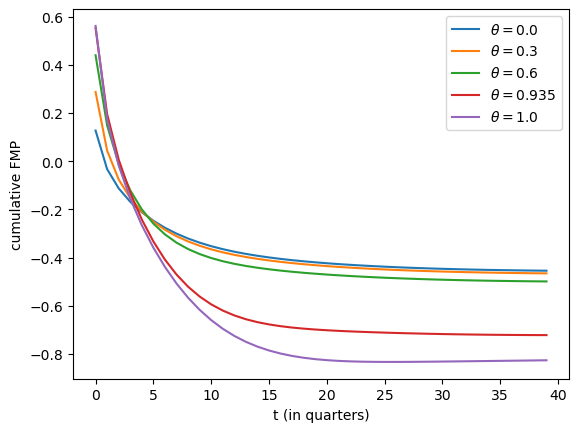

In [22]:
max_T = 40
fig, ax = plt.subplots()
for theta in theta_list:
    fmps = [calc_FMP(IRF_thetas[theta], ss.r, t) for t in range(max_T)]
    ax.plot(np.arange(max_T), fmps, label=f'$\\theta = {theta}$')
ax.set_xlabel('t (in quarters)')
ax.set_ylabel('cumulative FMP')
ax.legend()

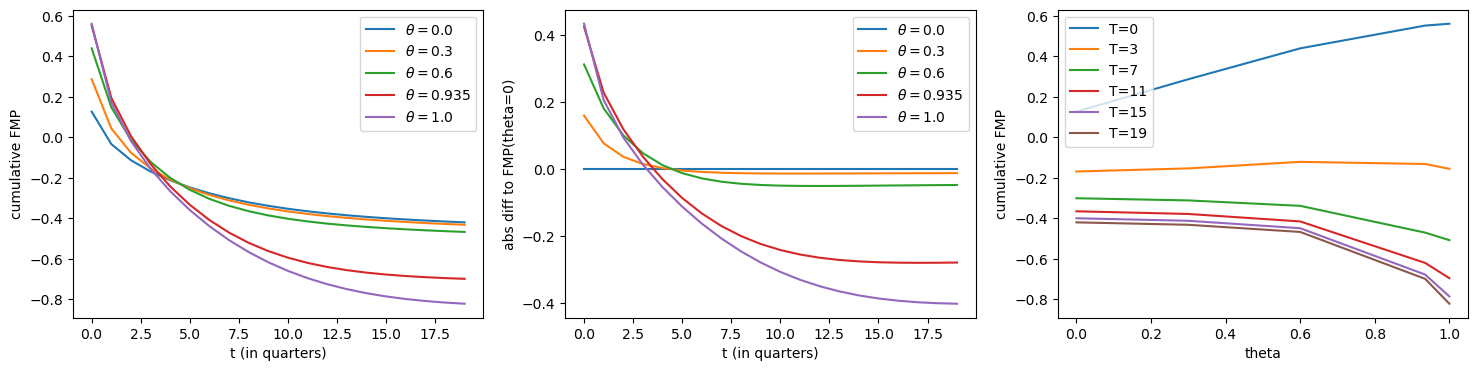

In [23]:
plot_FMPs(IRF_thetas)

In [24]:
# Dependence on rho_eg

## Active MP

In [32]:
model.par.phi_G = model_sticky.par.phi_G = 0.0
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government_constant_B',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']

In [26]:
phi_pis = [0.0, 1.0, 1.25, 1.5, 2.0]
IRFs_phi_pi = {}
IRFs_sticky_phi_pi = {}
for phi_pi in phi_pis:
    model.par.phi_pi = model_sticky.par.phi_pi = phi_pi
    calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg'])
    IRFs_phi_pi[phi_pi] = deepcopy(model.IRF)
    IRFs_sticky_phi_pi[phi_pi] = deepcopy(model_sticky.IRF)

Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 0.0
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 1.0
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 1.5
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 2.0
rho_m = 0.89

### shocks ###


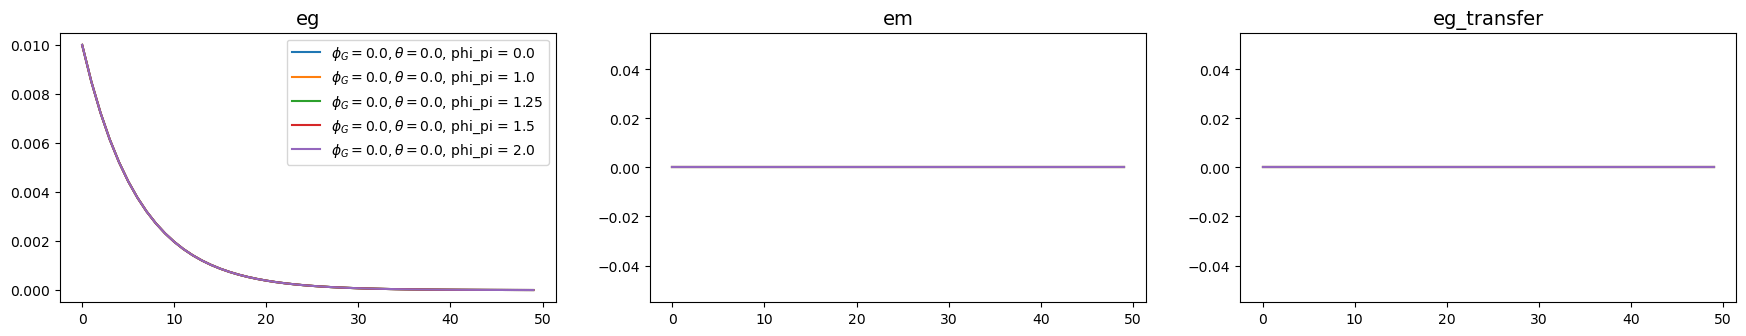


### varnames ###


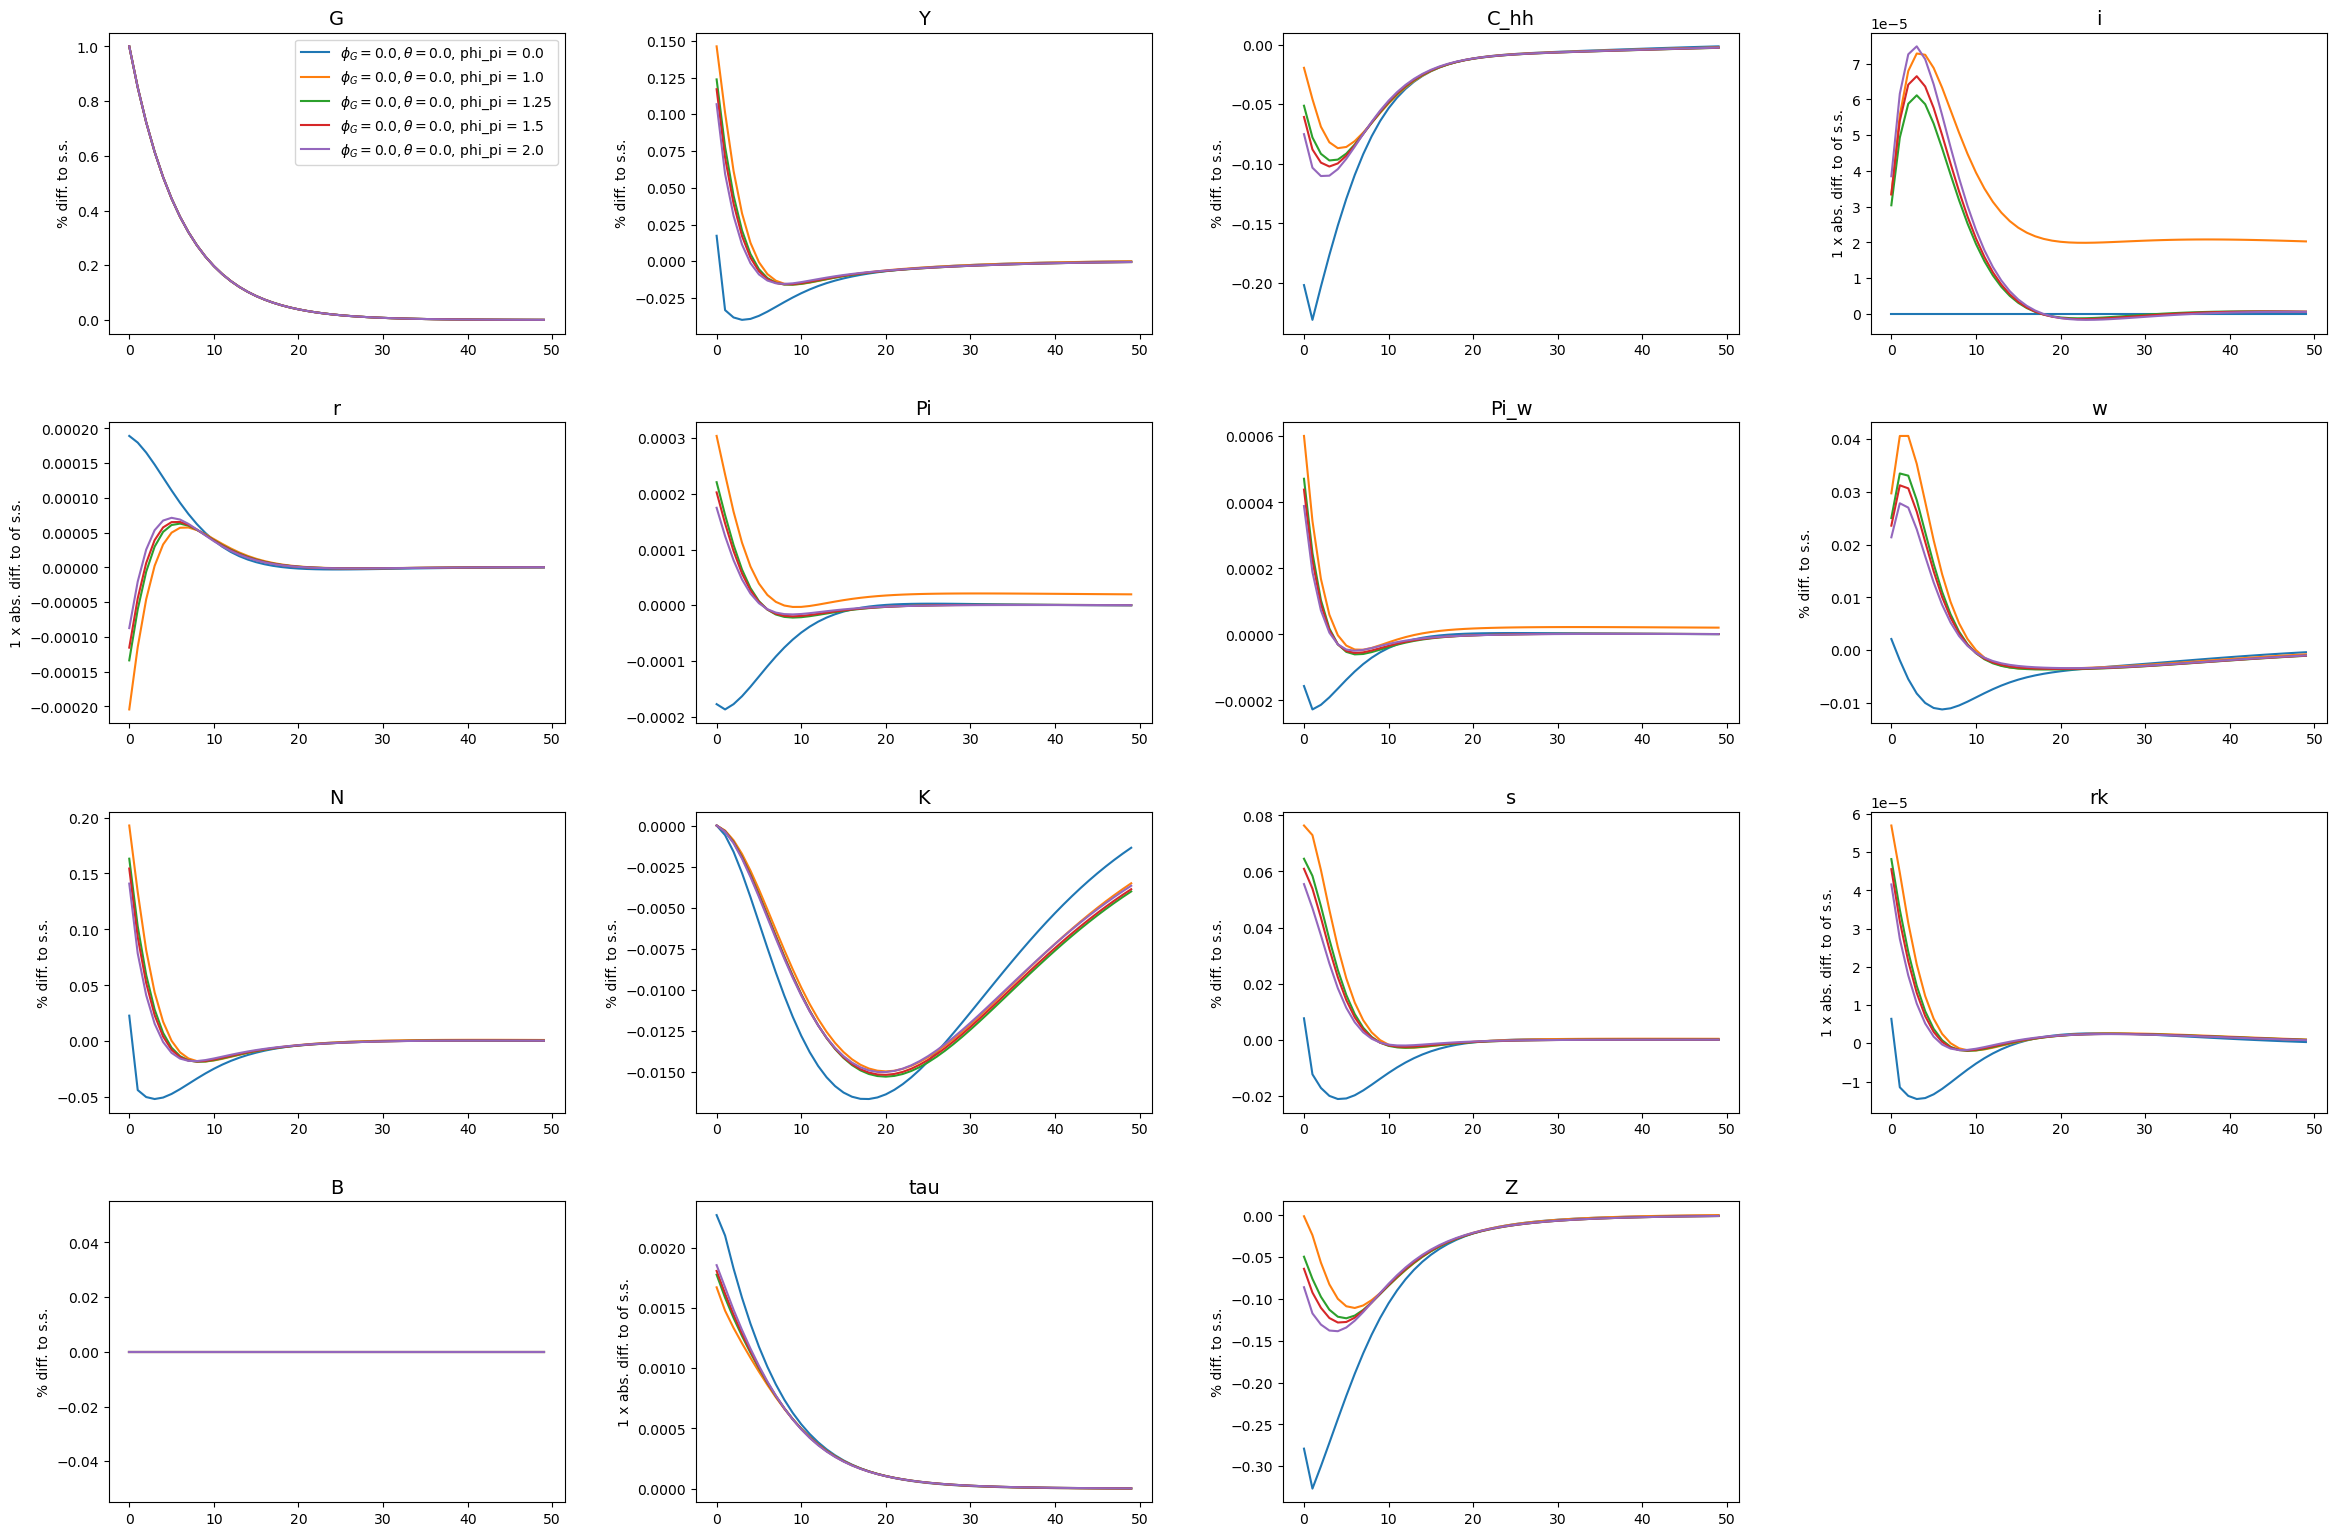


### tagets ###


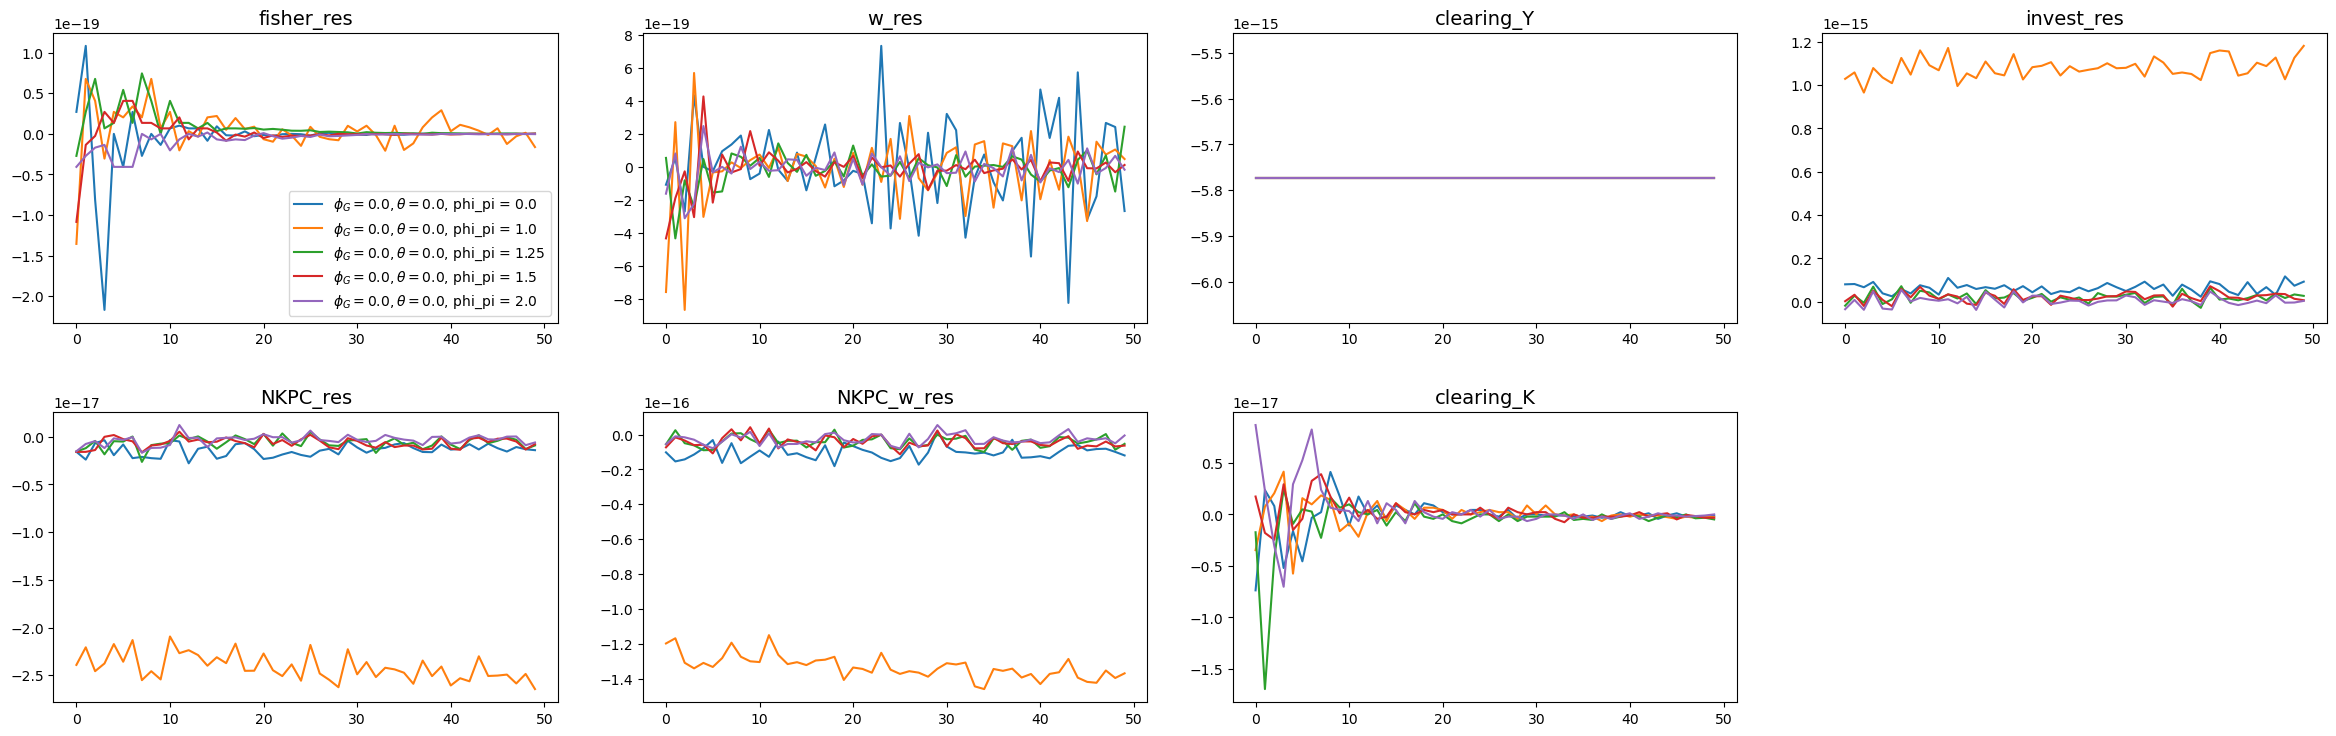

In [31]:
labels = [f'$\phi_G = {model.par.phi_G}, \\theta = {model.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
labels_sticky = [f'$\phi_G = {model_sticky.par.phi_G}, \\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
paths_short = ['G', 'Y', 'C_hh','i','r']
paths2 = ['G', 'Y', 'C_hh', 'i', 'r', 'Pi', 'Pi_w', 'w', 'N', 'K', 's', 'rk', 'B', 'tau', 'Z']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi','Pi_w']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra', 'Pi_w']
show_only_IRFs(model, list(IRFs_phi_pi.values()), labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)
show_only_IRFs(model_sticky, list(IRFs_sticky_phi_pi.values()), labels_sticky, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)

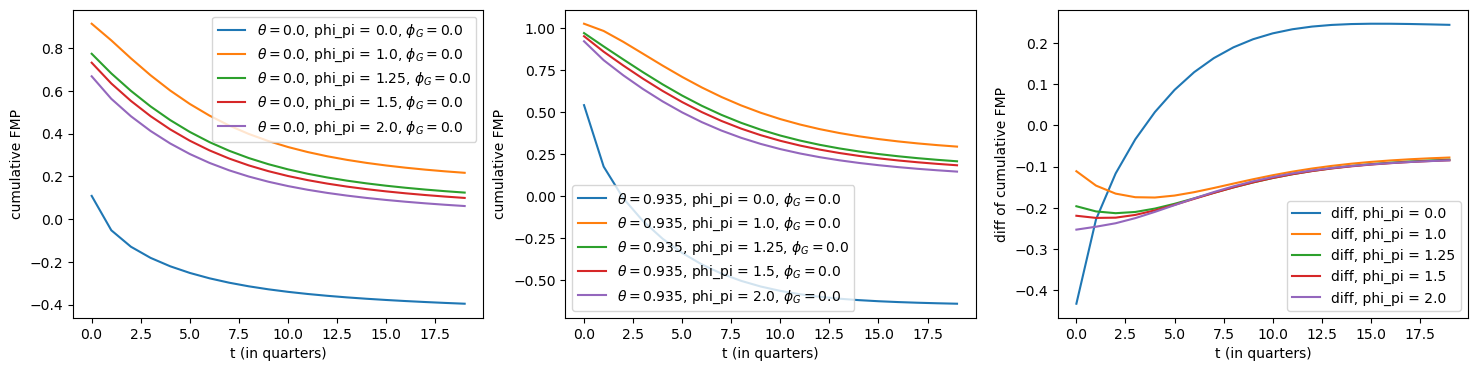

In [28]:
max_T = 20

ncols = 3
nrows = 1
fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)

ax1 = fig.add_subplot(nrows,ncols,1)
ax2 = fig.add_subplot(nrows,ncols,2)
ax3 = fig.add_subplot(nrows,ncols,3)

for phi_pi in phi_pis:
    fmps_no_sticky = [calc_FMP(IRFs_phi_pi[phi_pi], ss.r, t) for t in range(max_T)]
    ax1.plot(np.arange(max_T), fmps_no_sticky, label=f'$\\theta = {model.par.inattention}$, phi_pi = {phi_pi}, $\\phi_G = {model.par.phi_G}$')
    fmps_sticky = [calc_FMP(IRFs_sticky_phi_pi[phi_pi], ss.r, t) for t in range(max_T)]
    ax2.plot(np.arange(max_T), fmps_sticky, label=f'$\\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}, $\\phi_G = {model_sticky.par.phi_G}$')
    ax3.plot(np.arange(max_T), np.array(fmps_no_sticky) - np.array(fmps_sticky), label=f'diff, phi_pi = {phi_pi}')

ax1.set_xlabel('t (in quarters)')
ax1.set_ylabel('cumulative FMP')
ax2.set_xlabel('t (in quarters)')
ax2.set_ylabel('cumulative FMP')
ax3.set_xlabel('t (in quarters)')
ax3.set_ylabel('diff of cumulative FMP')
ax1.legend()
ax2.legend()
ax3.legend()

# Debt financed shock

In [28]:
model.par.phi_G = model_sticky.par.phi_G = 1.0
model.par.phi_pi = model_sticky.par.phi_pi = 0.0
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']

model.par.rho_eg = model_sticky.par.rho_eg = 0.85
model.par.jump_eg = model_sticky.par.jump_eg = 0.01
model.par.jump_eg_transfer = model_sticky.par.jump_eg_transfer = 0.0
model.par.jump_em = model_sticky.par.jump_em = 0.0
delta_G = model.par.jump_eg * model.par.rho_eg ** np.arange(model.par.T)
print(f'Shock with parameters jump = {model.par.jump_eg}, rho = {model.par.rho_eg} leads to a total spending increase of {delta_G.sum()*100:.2f}%')

Shock with parameters jump = 0.01, rho = 0.85 leads to a total spending increase of 6.67%


In [29]:
# compute jacs: model without sticky information
print('Compute Jacobians (no sticky) ')
assert model.par.inattention == 0.0
model._compute_jac(inputs='unknowns')
model._compute_jac(inputs='shocks')
# model.compute_jacs(do_print=False)
# compute jacs: model with sticky information
print('Compute Jacobians (sticky) ')
model_sticky.par.inattention = 0.935
model_sticky.jac_hh = deepcopy(model.jac_hh)
model_sticky.jac_hh = model_sticky._compute_sticky_jacs_hh(model_sticky.jac_hh)
model_sticky._compute_jac(inputs='unknowns')
model_sticky._compute_jac(inputs='shocks')
# model_sticky.compute_jacs(do_print=False)

# calc IRFs
print('find IRFs (no sticky)')
model.find_IRFs(shocks=['eg'])
print('find IRFs (sticky)')
model_sticky.find_IRFs(shocks=['eg'])

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)


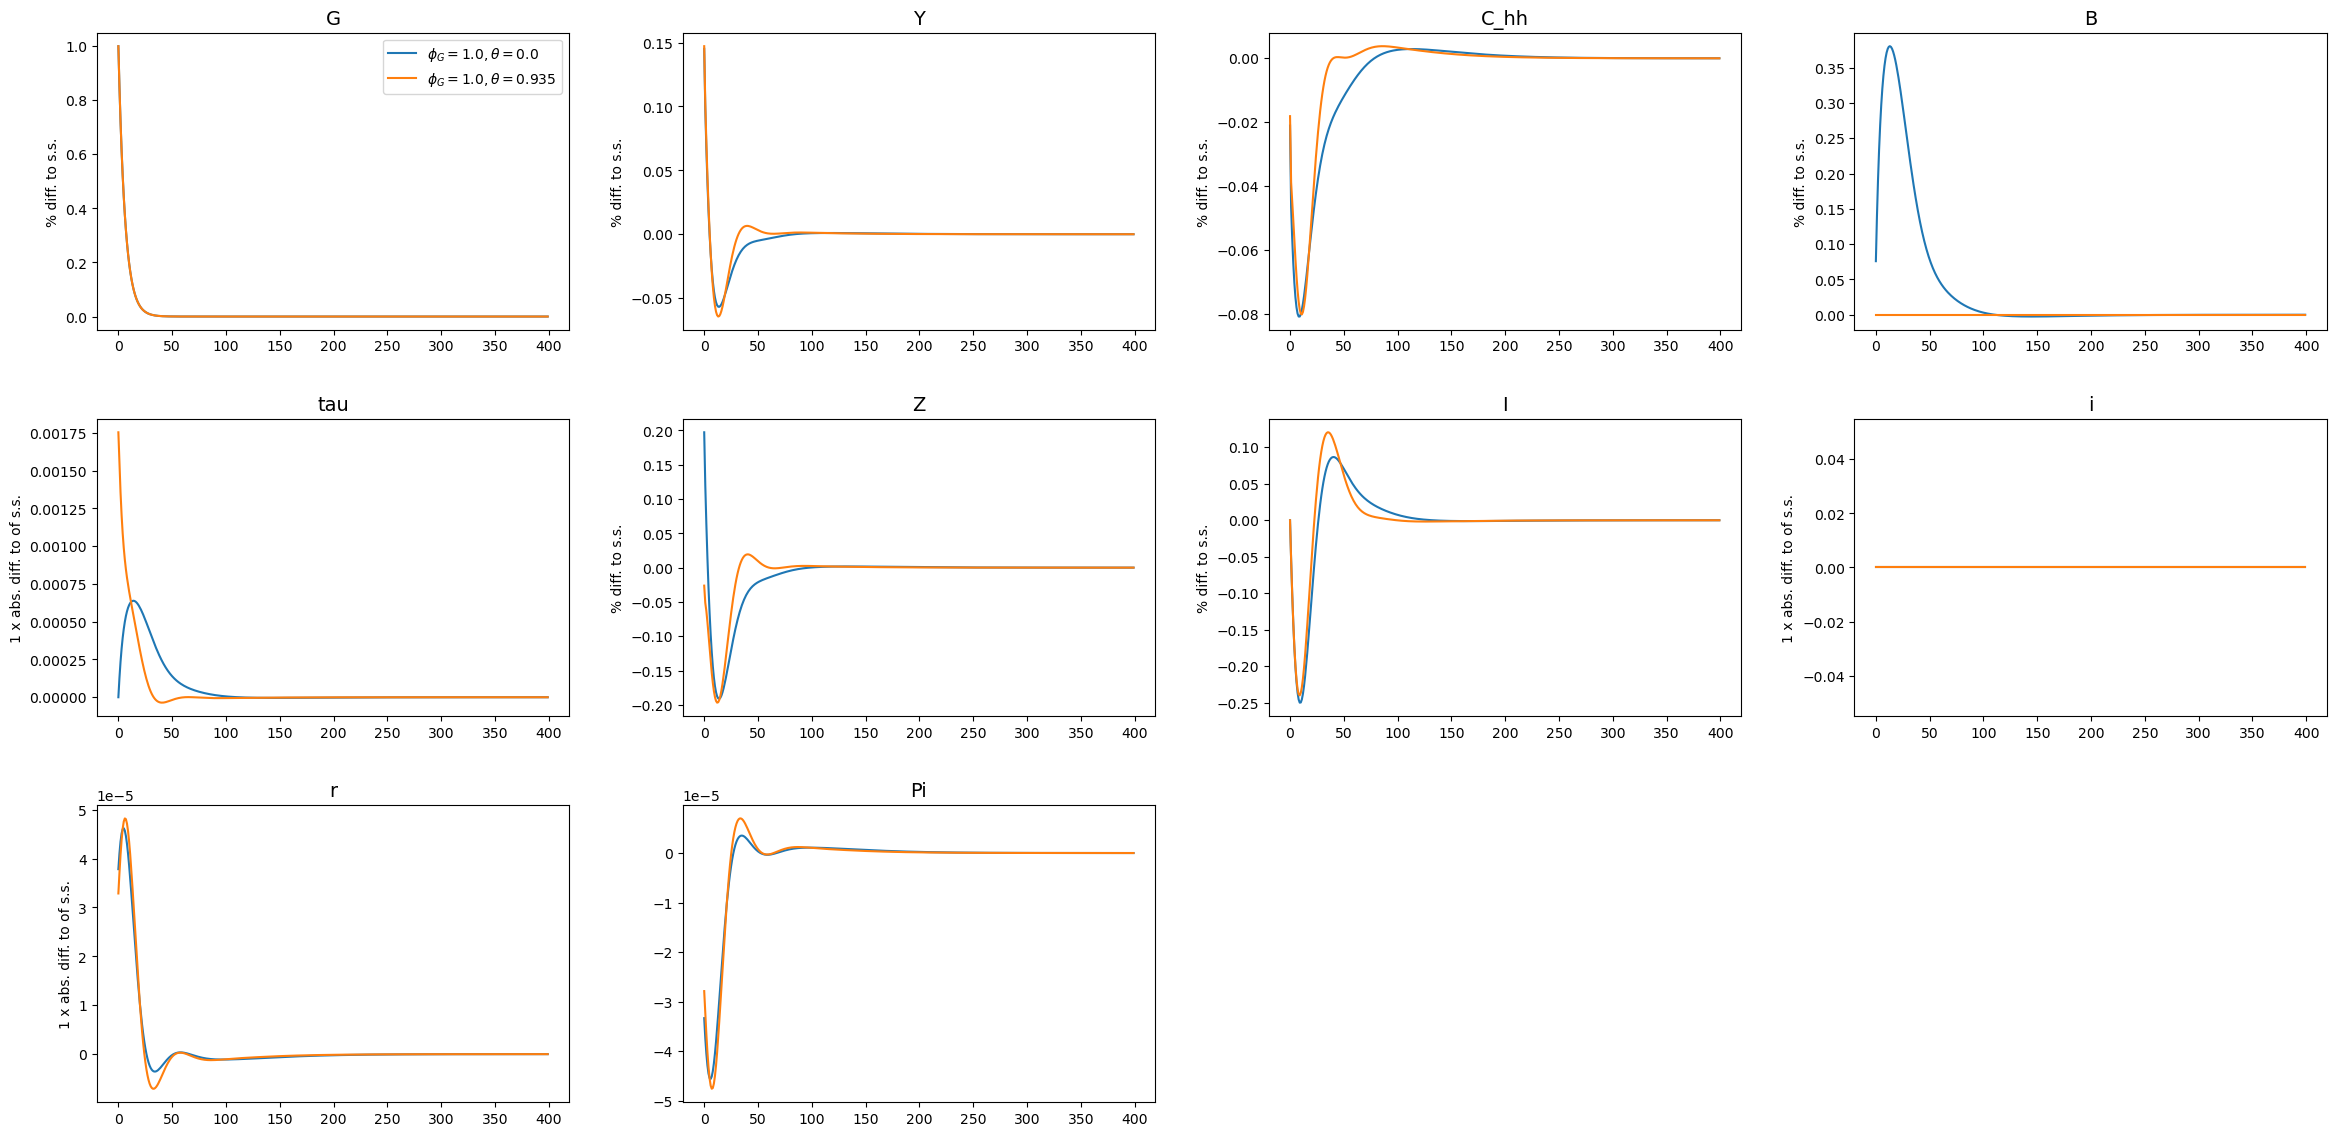

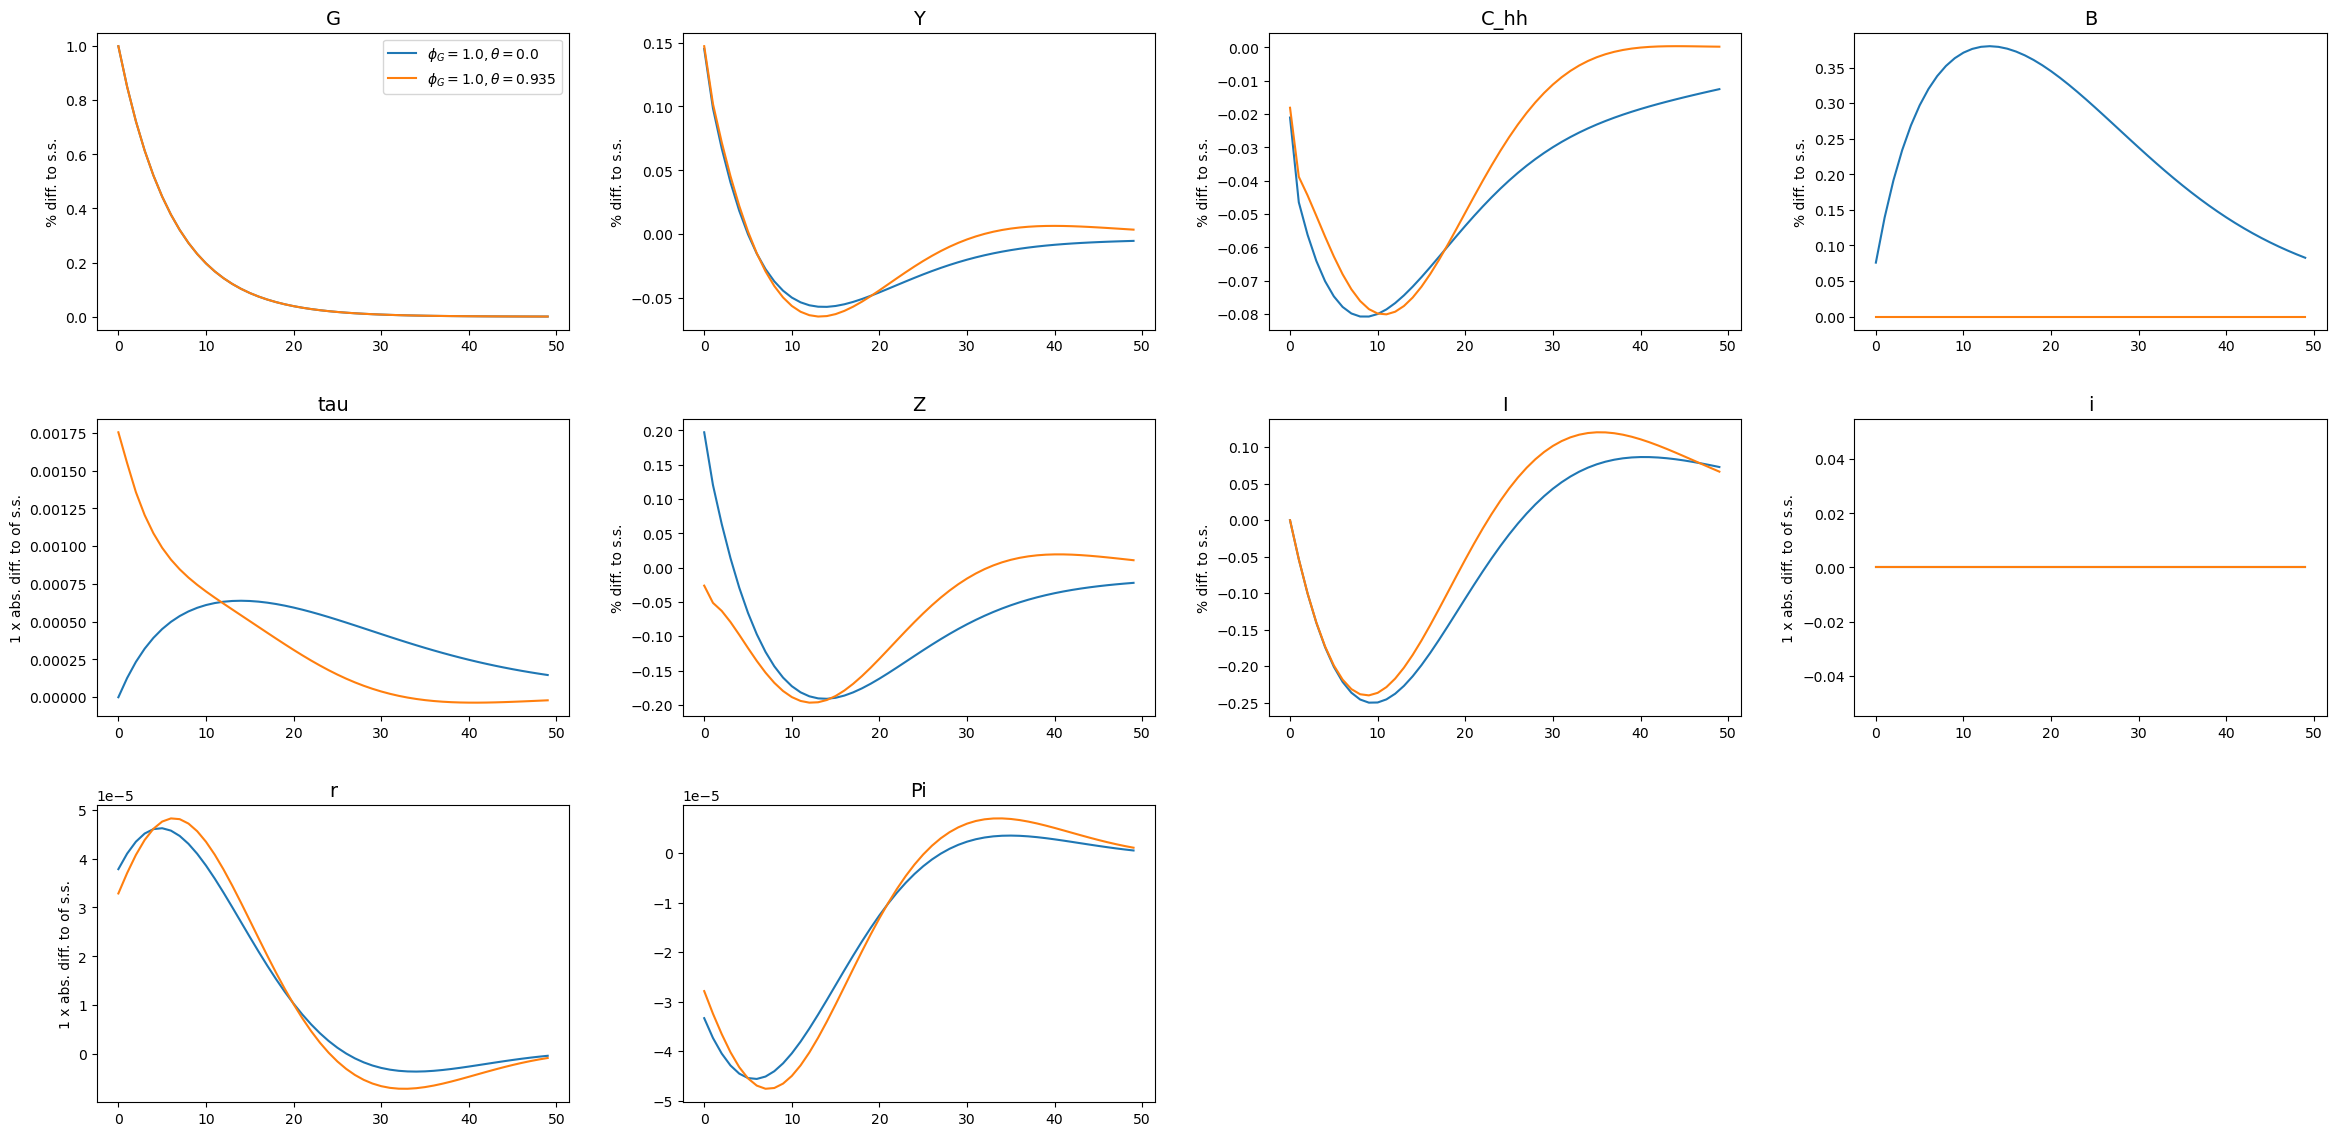

In [30]:
models = [model, model_sticky]
labels = [f'$\phi_G = {m.par.phi_G}, \\theta = {m.par.inattention}$' for m in models]
paths_short = ['G', 'Y', 'C_hh', 'B', 'tau', 'Z', 'I','i','r','Pi']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra']
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False)
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False, T_max=50)

In [31]:
IRF_thetas = {}
print(f'calc IRFs for phi_G = {model.par.phi_G} and ...')
for theta in theta_list:
    print(f'theta: {theta}')
    model_temp = deepcopy(model)
    model_temp.par.inattention = theta
    model_temp.jac_hh = jacs_hh_thetas[theta]
    model_temp._compute_jac(inputs='unknowns',do_print=False)
    model_temp._compute_jac(inputs='shocks',do_print=False)
    model_temp.find_IRFs(shocks=['eg'])
    IRF_thetas[theta] = deepcopy(model_temp.IRF)

calc IRFs for phi_G = 1.0 and ...
theta: 0.0
theta: 0.3
theta: 0.6
theta: 0.935
theta: 1.0


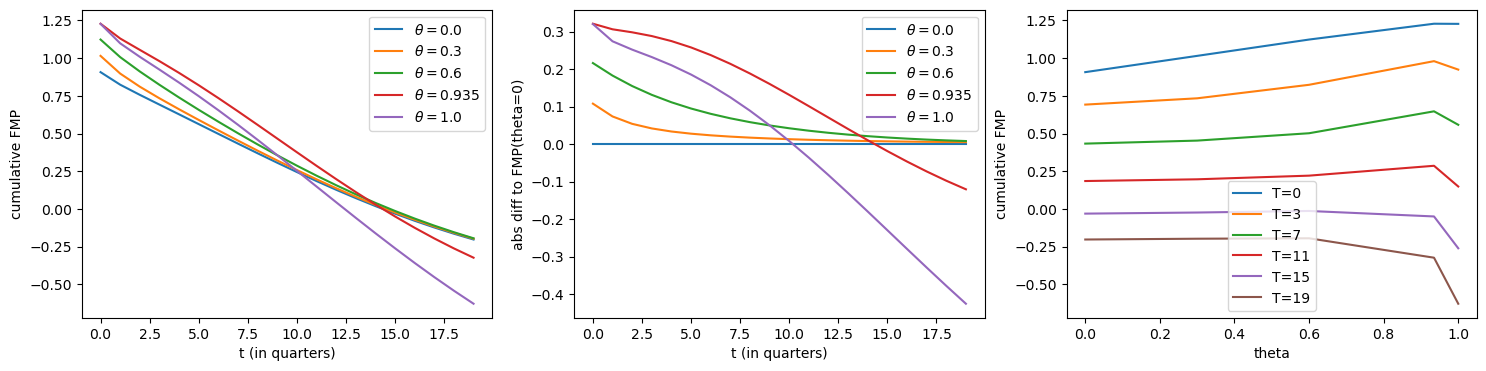

In [32]:
plot_FMPs(IRF_thetas)

## Active MP

In [33]:
model.par.phi_G = model_sticky.par.phi_G = 1.0
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']
# model.par.rho_eg = model_sticky.par.rho_eg = 0.85
# delta_G = model.par.jump_eg * model.par.rho_eg ** np.arange(model.par.T)
# print(f'Shock with parameters jump = {model.par.jump_eg}, rho = {model.par.rho_eg} leads to a total spending increase of {delta_G.sum()*100:.2f}%')

In [34]:
phi_pis = [0.0, 1.0, 1.25, 1.5, 2.0]
IRFs_phi_pi = {}
IRFs_sticky_phi_pi = {}
for phi_pi in phi_pis:
    model.par.phi_pi = model_sticky.par.phi_pi = phi_pi
    calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg'])
    IRFs_phi_pi[phi_pi] = deepcopy(model.IRF)
    IRFs_sticky_phi_pi[phi_pi] = deepcopy(model_sticky.IRF)

Fiscal policy settings:
phi_G = 1.0
phi_tau = 0.1
phi_pi = 0.0
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 1.0
phi_tau = 0.1
phi_pi = 1.0
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 1.0
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 1.0
phi_tau = 0.1
phi_pi = 1.5
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)
Fiscal policy settings:
phi_G = 1.0
phi_tau = 0.1
phi_pi = 2.0
rho_m = 0.89

### shocks ###


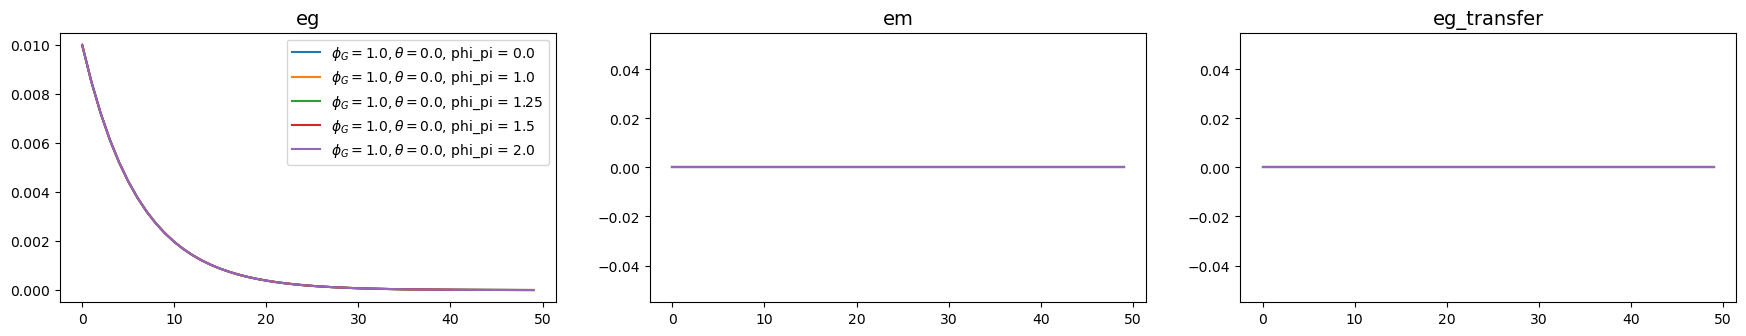


### varnames ###


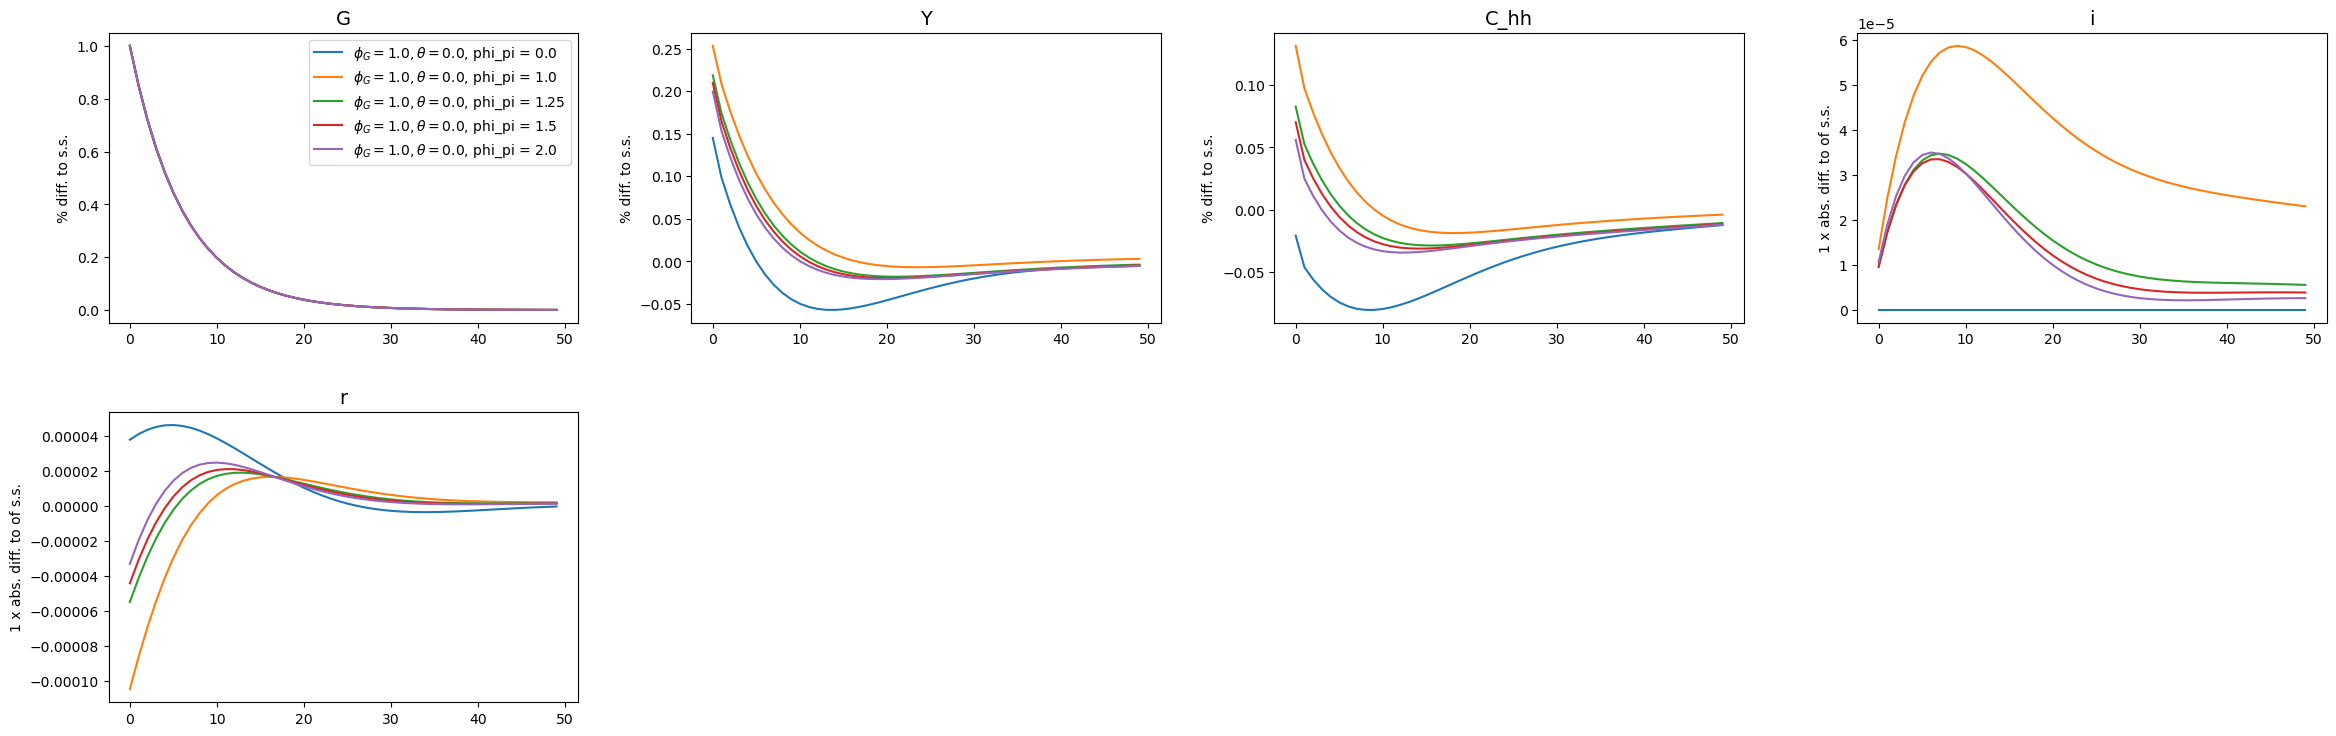


### tagets ###


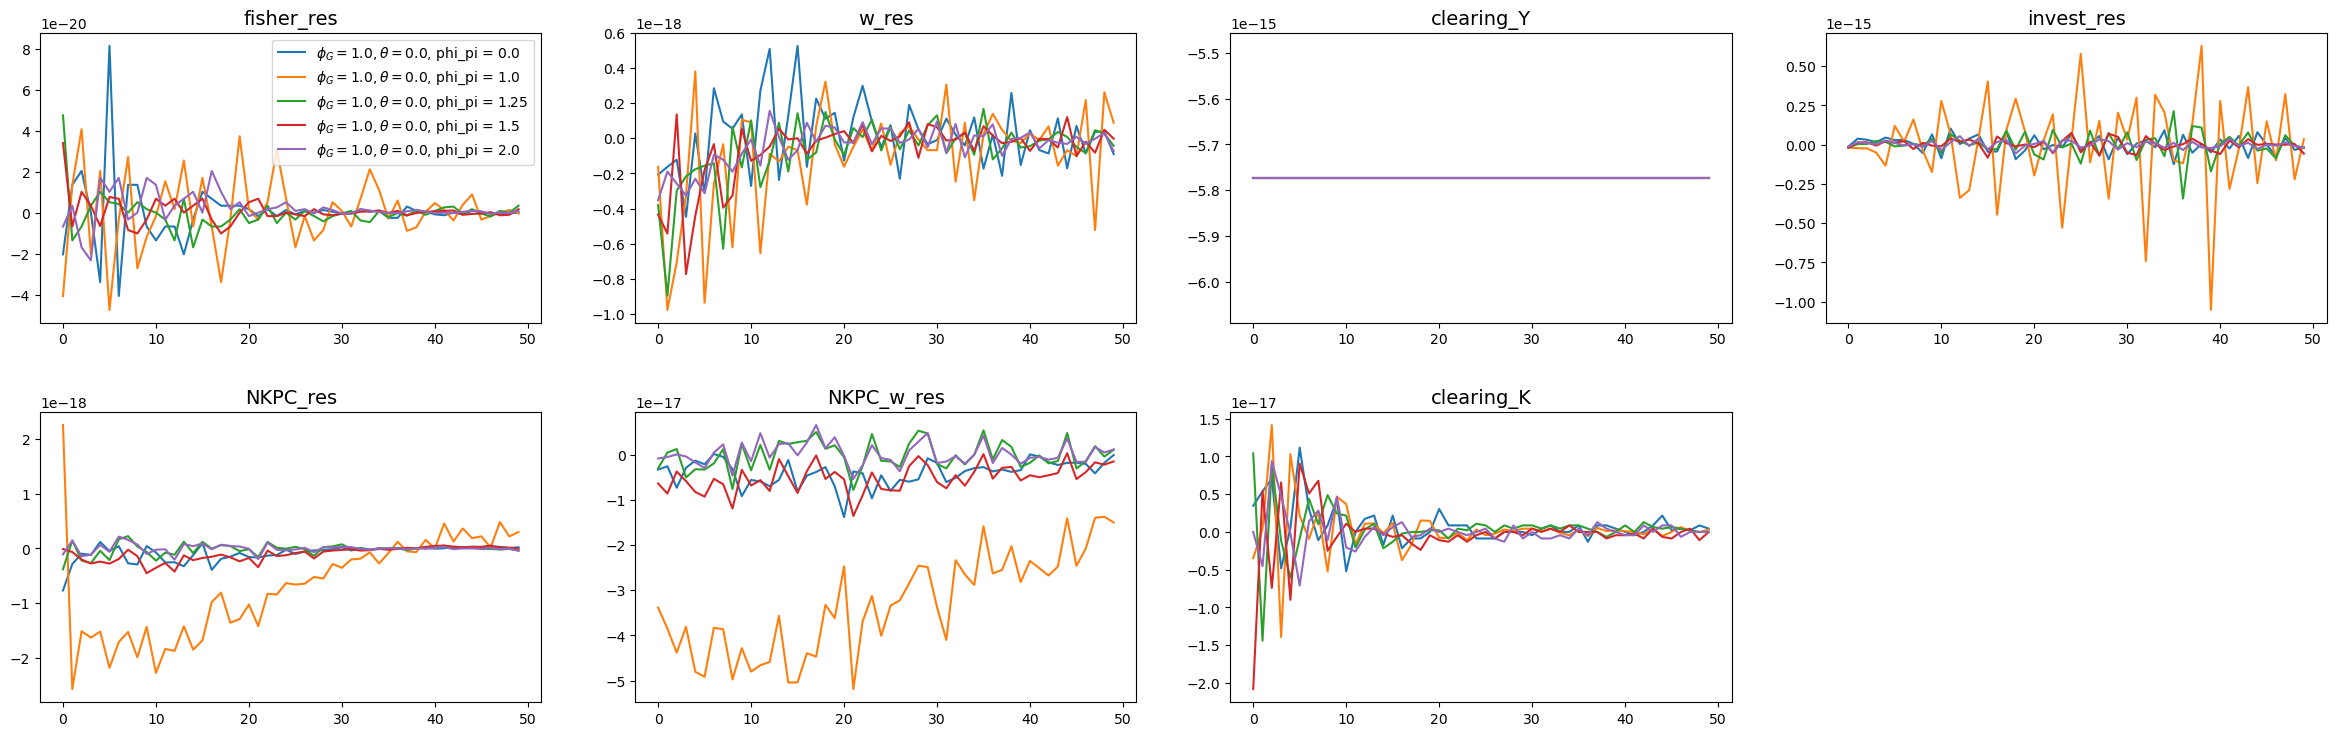


### shocks ###


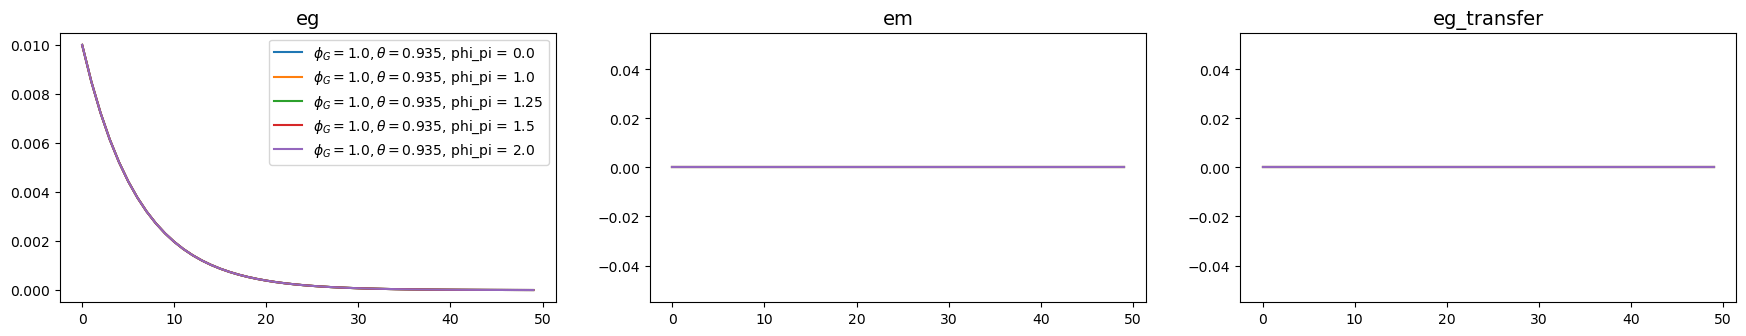


### varnames ###


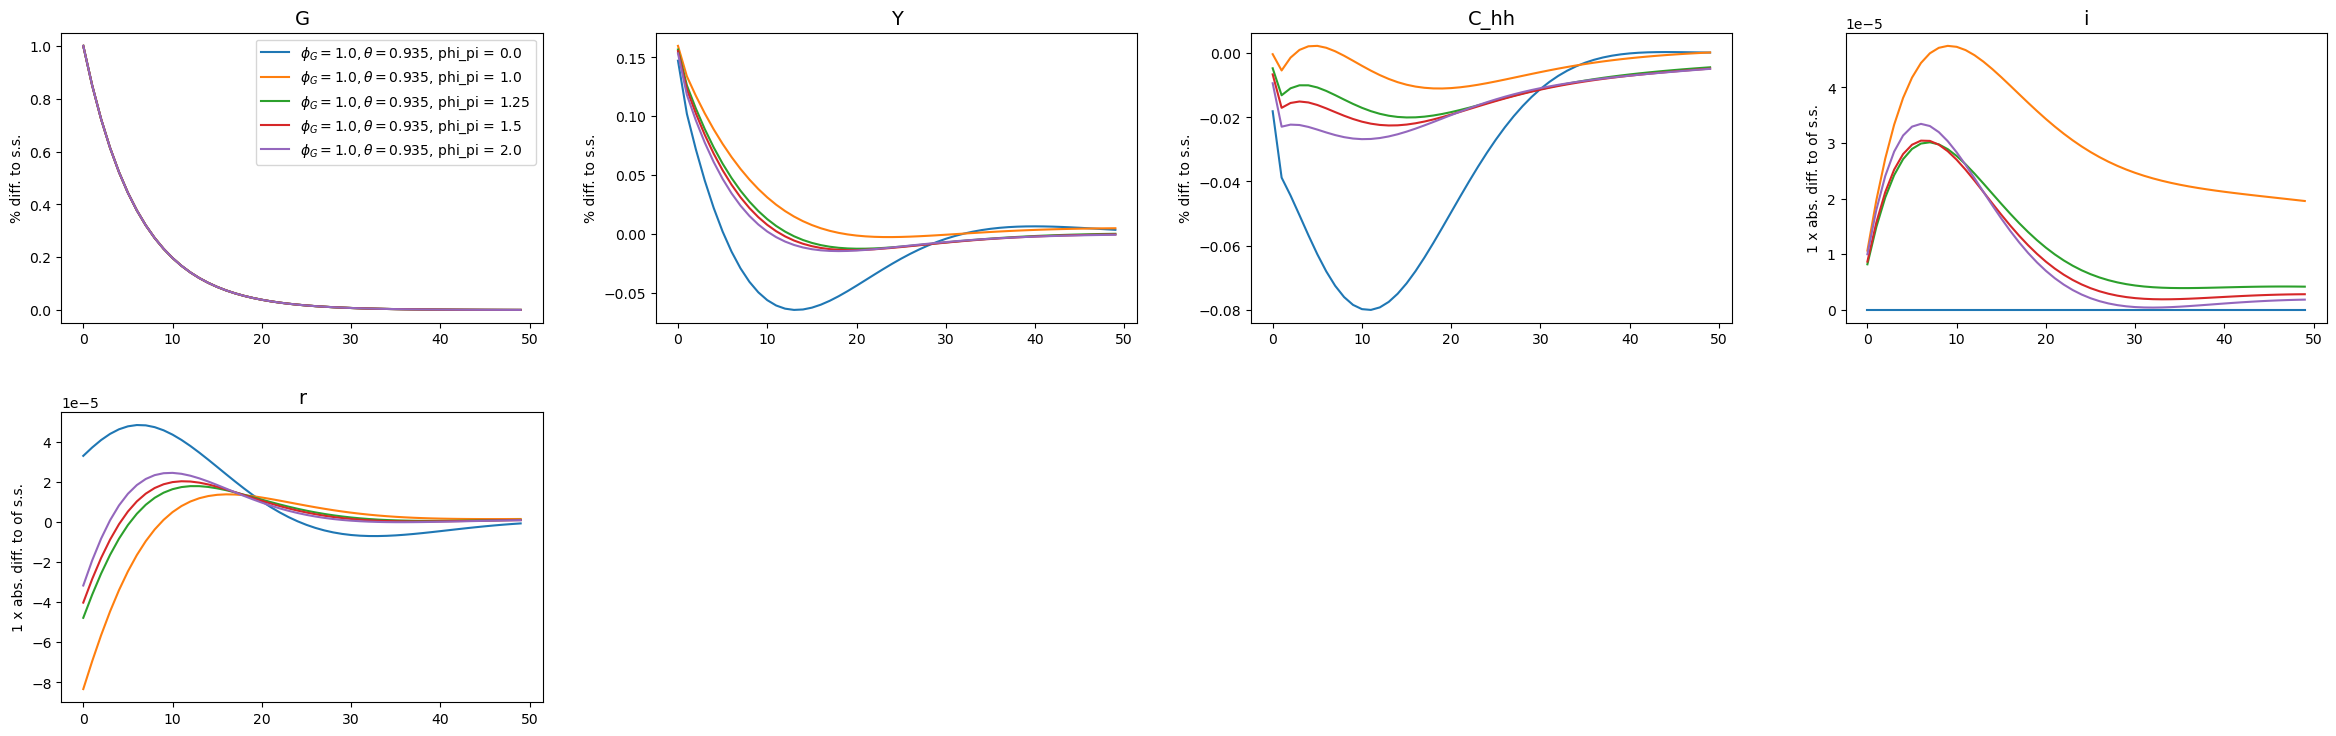


### tagets ###


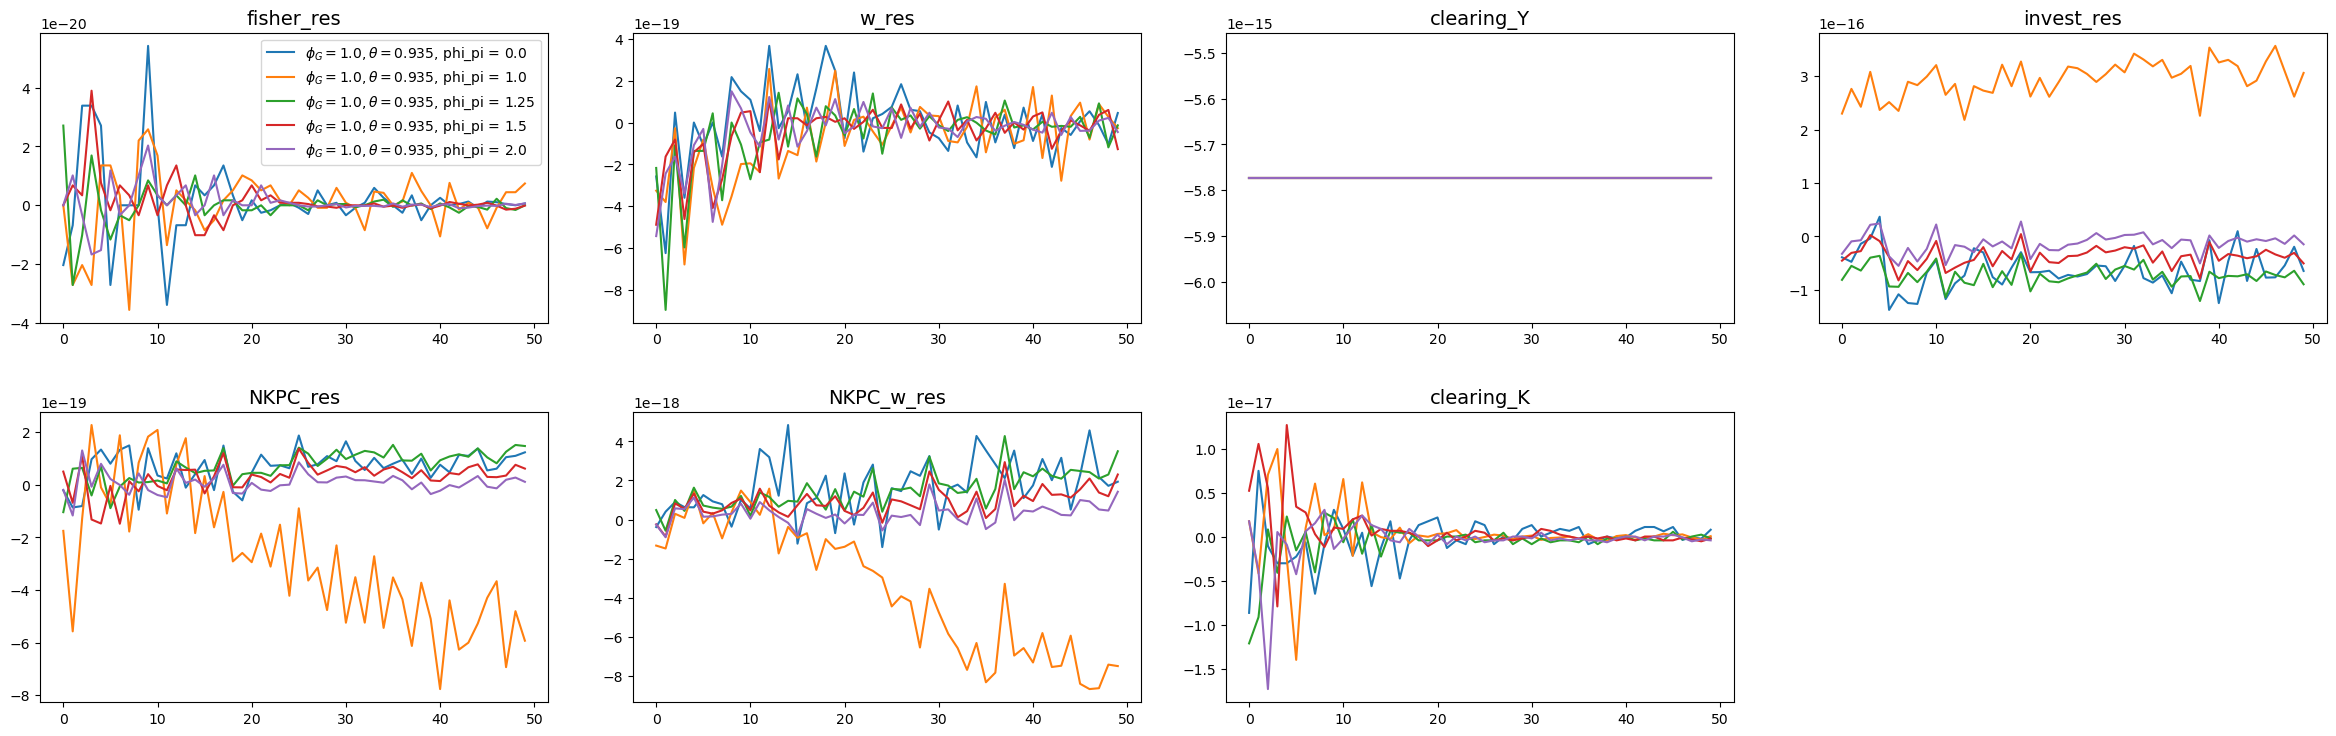

In [35]:
labels = [f'$\phi_G = {model.par.phi_G}, \\theta = {model.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
labels_sticky = [f'$\phi_G = {model_sticky.par.phi_G}, \\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
paths_short = ['G', 'Y', 'C_hh','i','r']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra']
show_only_IRFs(model, list(IRFs_phi_pi.values()), labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)
show_only_IRFs(model_sticky, list(IRFs_sticky_phi_pi.values()), labels_sticky, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)

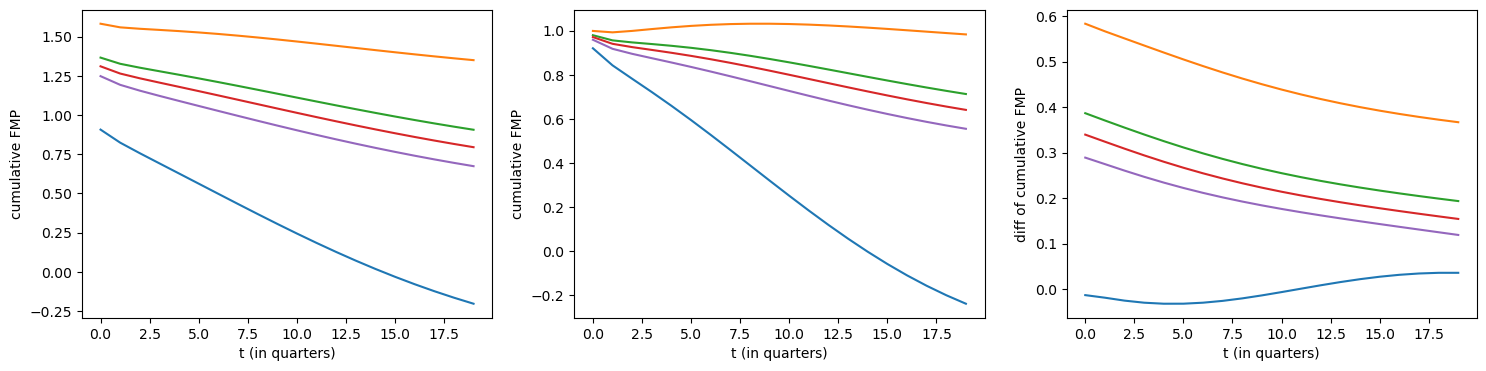

In [36]:
max_T = 20

ncols = 3
nrows = 1
fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)

ax1 = fig.add_subplot(nrows,ncols,1)
ax2 = fig.add_subplot(nrows,ncols,2)
ax3 = fig.add_subplot(nrows,ncols,3)

for phi_pi in phi_pis:
    fmps_no_sticky = [calc_FMP(IRFs_phi_pi[phi_pi], ss.r, t) for t in range(max_T)]
    ax1.plot(np.arange(max_T), fmps_no_sticky, label=f'$\\theta = {model.par.inattention}$, phi_pi = {phi_pi}, $\\phi_G = {model.par.phi_G}$')
    fmps_sticky = [calc_FMP(IRFs_sticky_phi_pi[phi_pi], ss.r, t) for t in range(max_T)]
    ax2.plot(np.arange(max_T), fmps_sticky, label=f'$\\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}, $\\phi_G = {model_sticky.par.phi_G}$')
    ax3.plot(np.arange(max_T), np.array(fmps_no_sticky) - np.array(fmps_sticky), label=f'diff, phi_pi = {phi_pi}')

ax1.set_xlabel('t (in quarters)')
ax1.set_ylabel('cumulative FMP')
ax2.set_xlabel('t (in quarters)')
ax2.set_ylabel('cumulative FMP')
ax3.set_xlabel('t (in quarters)')
ax3.set_ylabel('diff of cumulative FMP')
ax.legend()

# Transfer shock
If tax-financed, the transfer shock is basically redistribution from productive to unproductive inidivuals?

In [37]:
model.par.phi_G = model_sticky.par.phi_G = 1.0
model.par.phi_pi = model_sticky.par.phi_pi = 0.0
model.par.jump_eg = model_sticky.par.jump_eg = 0.0
model.par.jump_eg_transfer = model_sticky.par.jump_eg_transfer = 0.0016
model.par.rho_eg_transfer = model_sticky.par.rho_eg_transfer = 0.9
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']

# shock_path = [model.par.jump_eg_transfer * model.par.rho_eg_transfer ** t if t < 40 else 0.0 for t in range(model.par.T)]
# shock_dict = {'deg_transfer': np.array(shock_path)}

delta_G = model.par.jump_eg_transfer * model.par.rho_eg_transfer ** np.arange(model.par.T)
delta_Ze = ss.Z * model.par.jump_eg_transfer * model.par.rho_eg_transfer ** np.arange(model.par.T)
print(f'Shock with parameters jump = {model.par.jump_eg_transfer}, rho = {model.par.rho_eg_transfer} leads to a total spending increase of {(delta_G.sum()/ss.G) *100:.2f}%')
print(f'And an increase in aggregate labor income of {delta_Ze.sum():.2f} equal to {(delta_Ze.sum() / ss.Z)*100:.2f}% of aggregate afte-tax labor income')


Shock with parameters jump = 0.0016, rho = 0.9 leads to a total spending increase of 10.00%
And an increase in aggregate labor income of 0.01 equal to 1.60% of aggregate afte-tax labor income


In [38]:
calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg_transfer'])
# find_IRFs(model, model_sticky, shocks=['eg_transfer'])
# find_IRFs(model, model_sticky, shock_dict)

Fiscal policy settings:
phi_G = 1.0
phi_tau = 0.1
phi_pi = 0.0
rho_m = 0.89

shock settings:
shock: eg_transfer -> jump = 0.0016, rho = 0.9

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)


### shocks ###


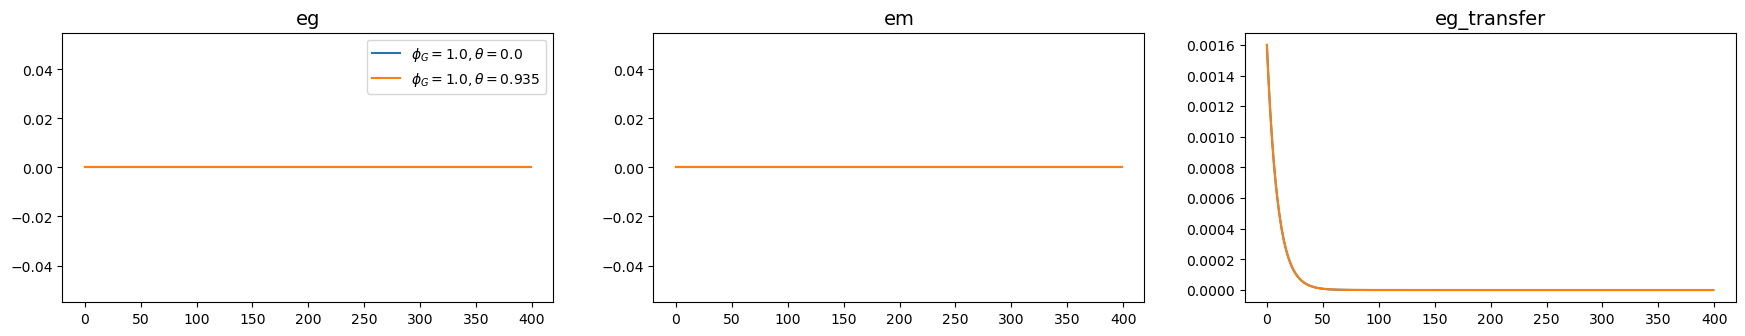


### varnames ###


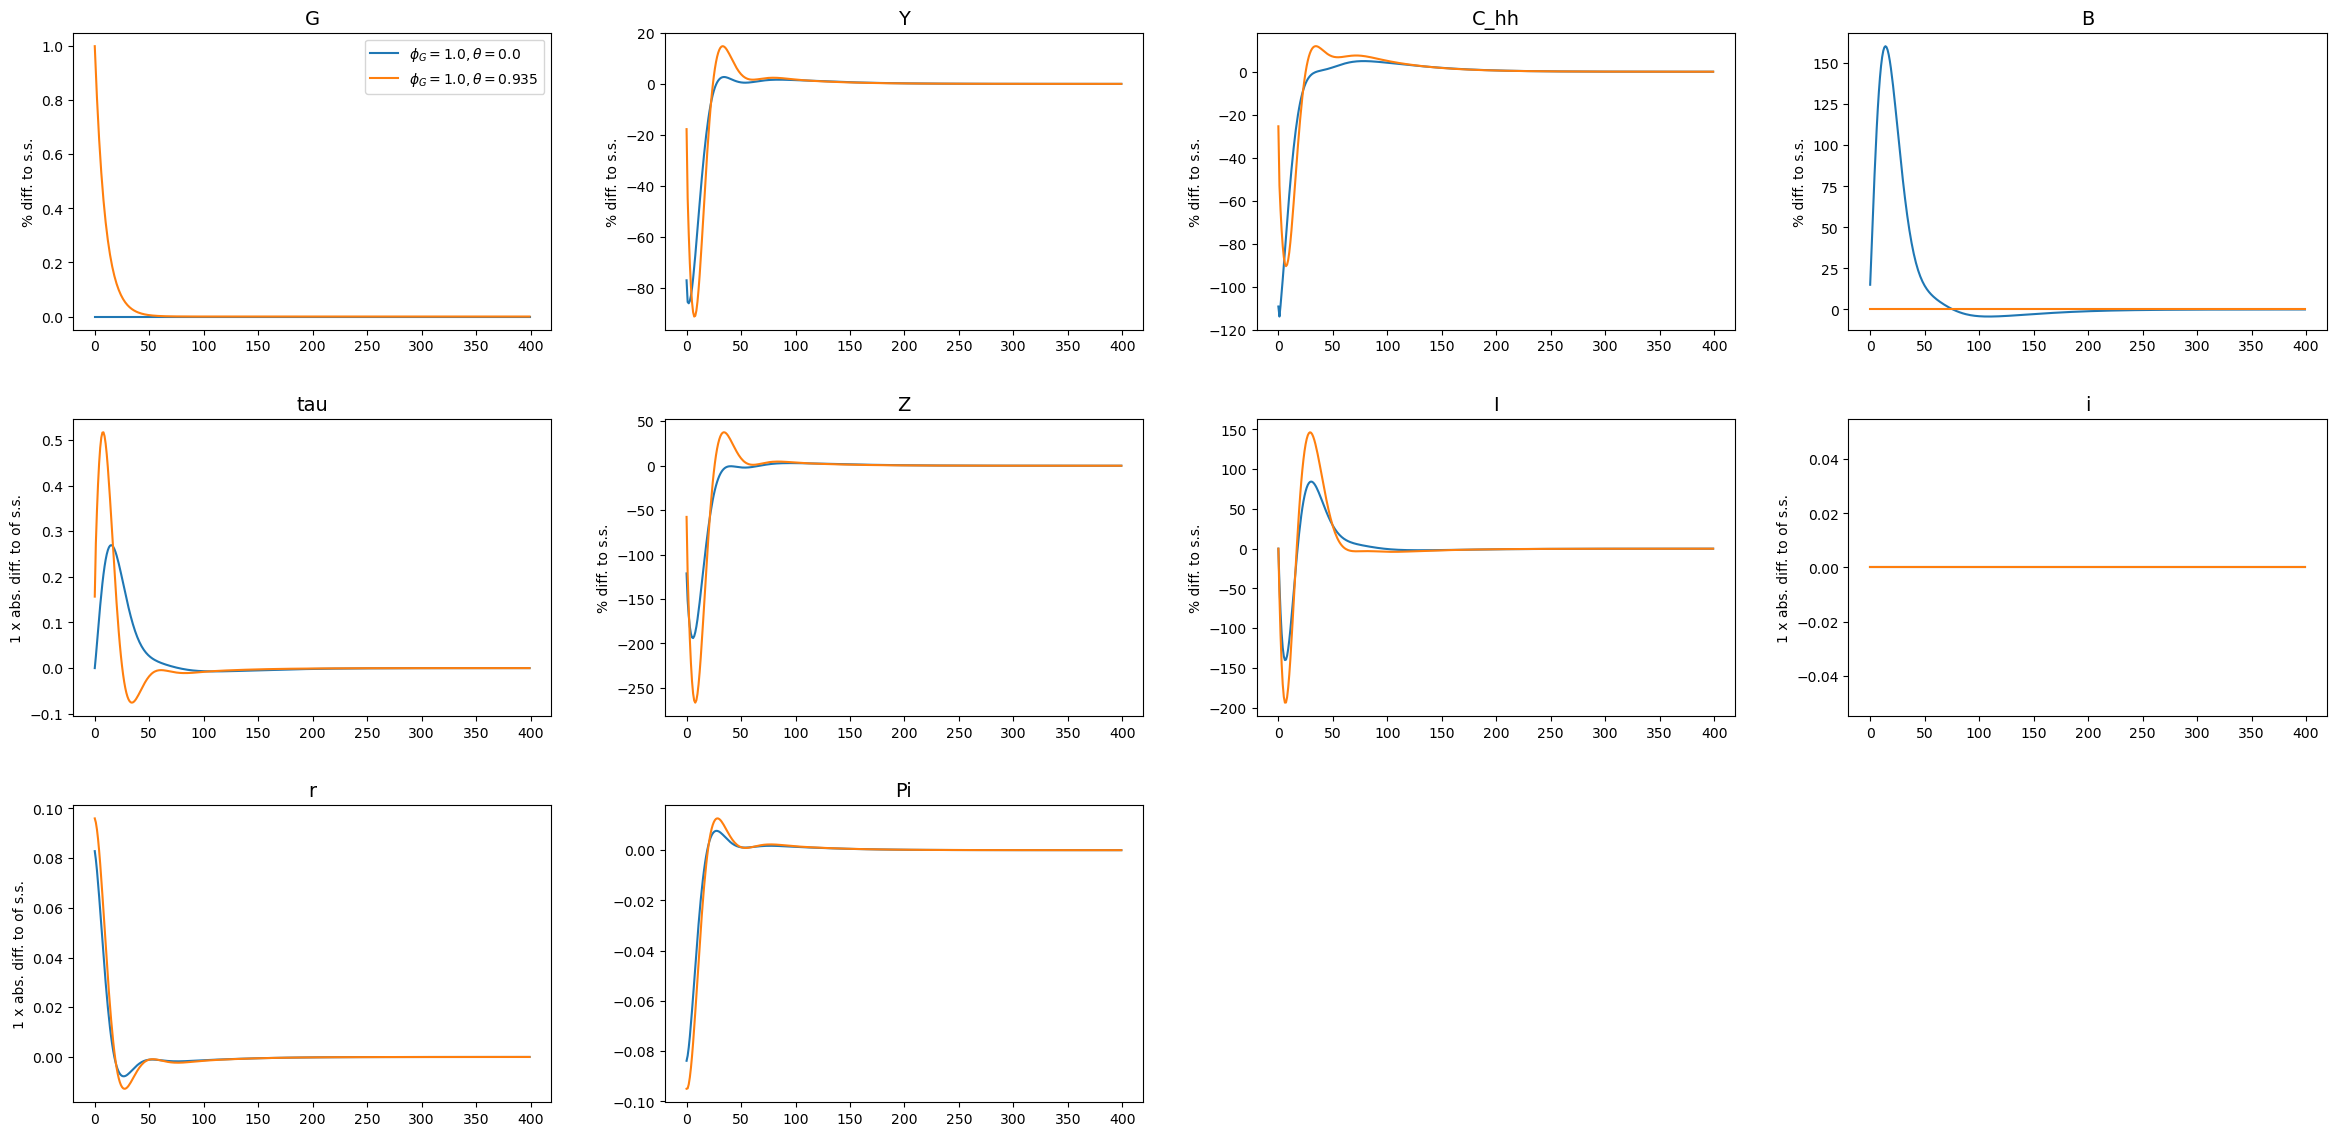

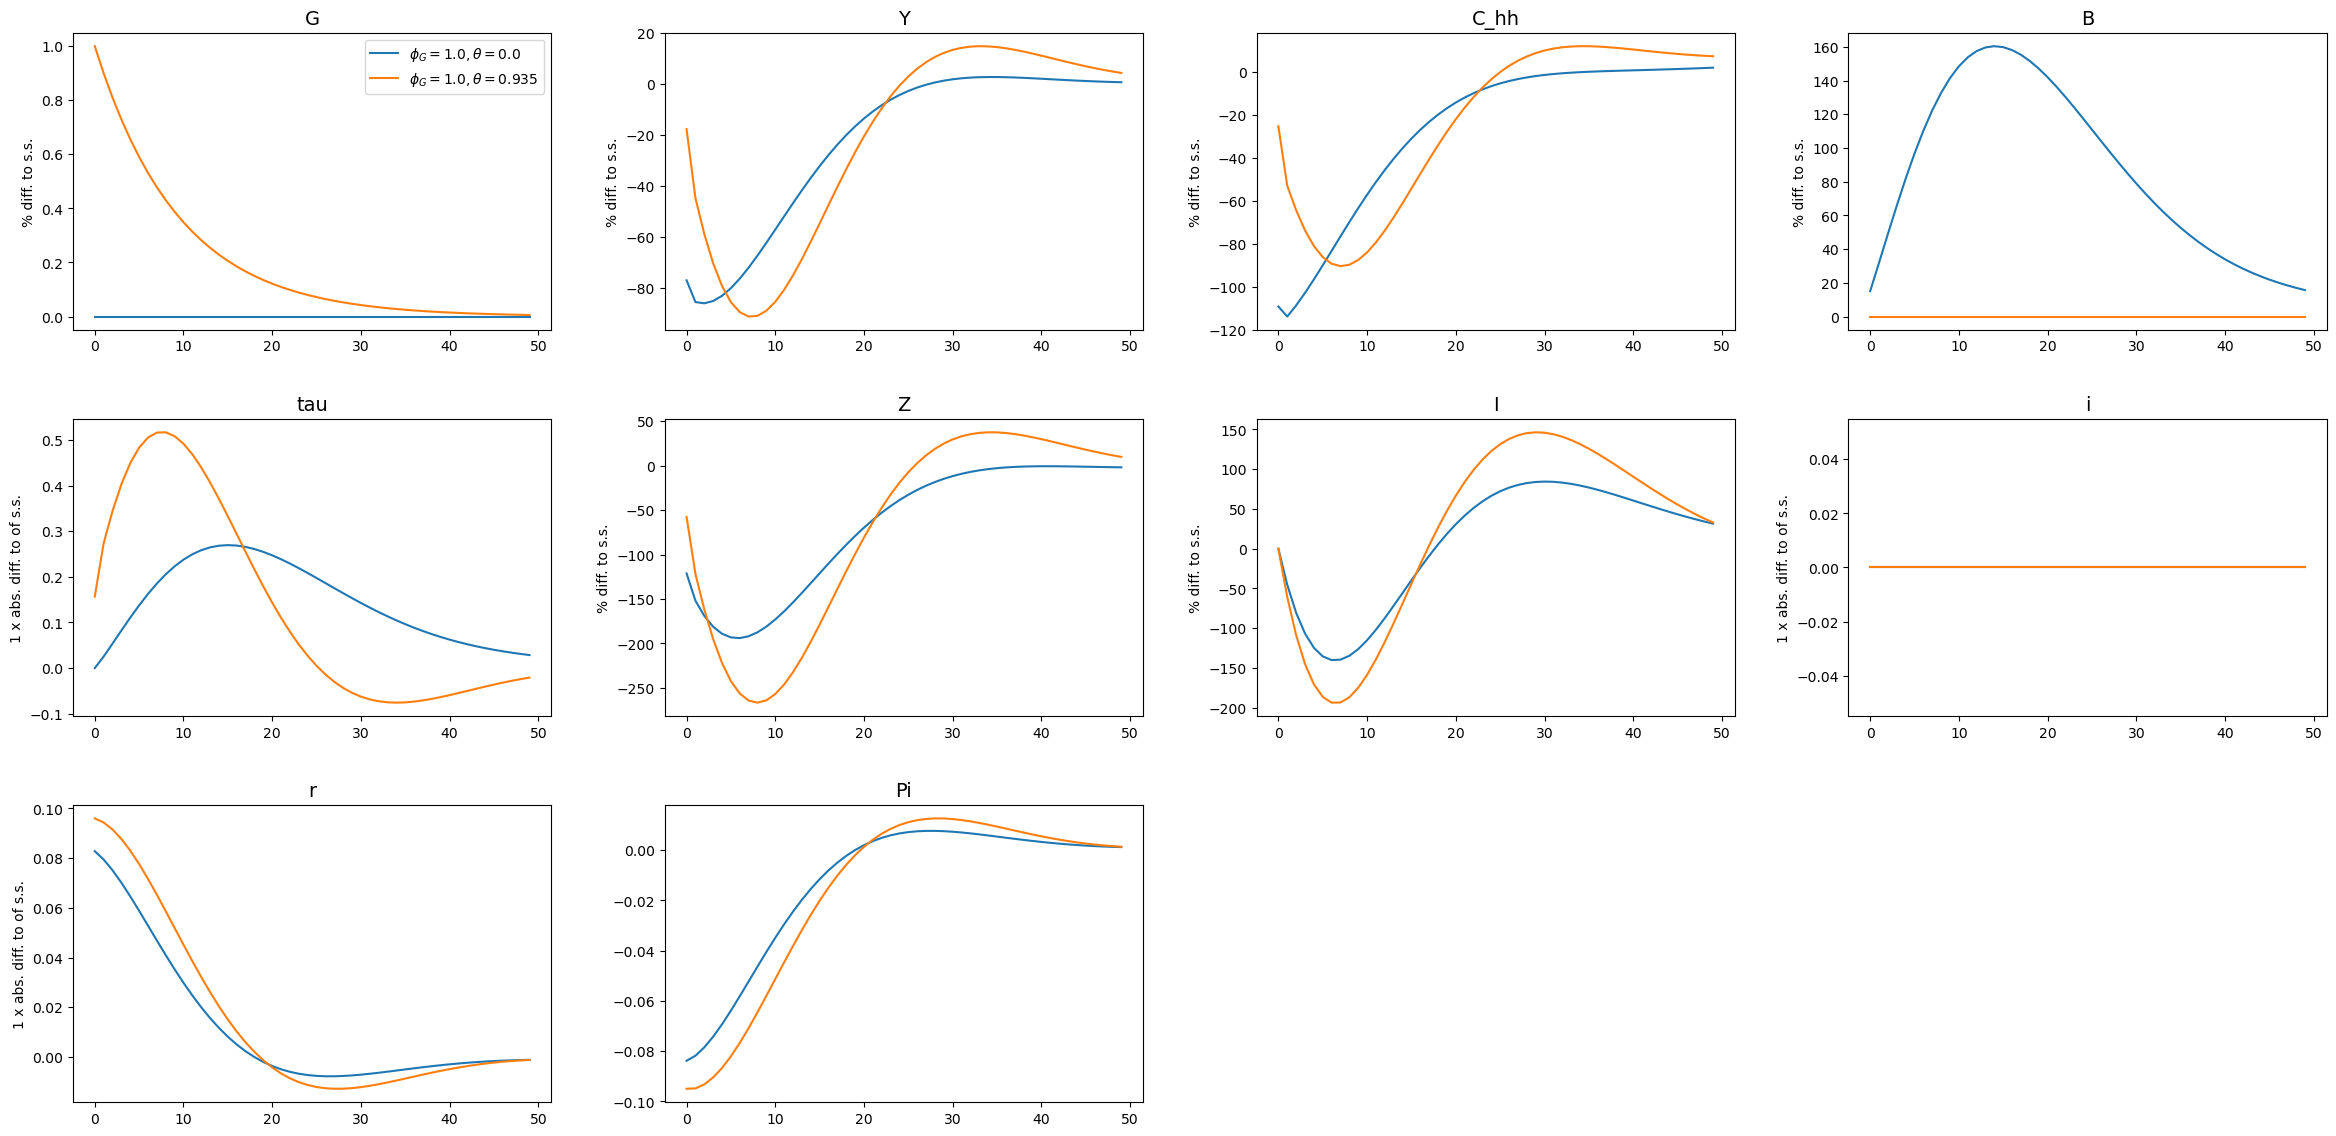

In [39]:
models = [model, model_sticky]
labels = [f'$\phi_G = {m.par.phi_G}, \\theta = {m.par.inattention}$' for m in models]
paths_short = ['G', 'Y', 'C_hh', 'B', 'tau', 'Z', 'I','i','r','Pi']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra']
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=True)
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False, T_max=50)

In [40]:
IRF_thetas = {}
print(f'calc IRFs for phi_G = {model.par.phi_G} and ...')
for theta in theta_list:
    print(f'theta: {theta}')
    model_temp = deepcopy(model)
    model_temp.par.inattention = theta
    model_temp.jac_hh = jacs_hh_thetas[theta]
    model_temp._compute_jac(inputs='unknowns',do_print=False)
    model_temp._compute_jac(inputs='shocks',do_print=False)
    model_temp.find_IRFs(shocks=['eg_transfer'])
    IRF_thetas[theta] = deepcopy(model_temp.IRF)

calc IRFs for phi_G = 1.0 and ...
theta: 0.0
theta: 0.3
theta: 0.6
theta: 0.935
theta: 1.0


AssertionError: t=0, G == 0 -> divide error in fiscal multiplier

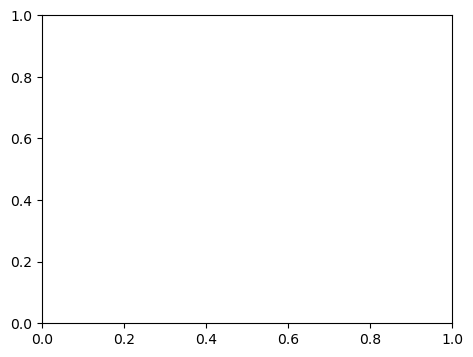

In [41]:
plot_FMPs(IRF_thetas)

## Active MP

In [ ]:
model.par.phi_G = model_sticky.par.phi_G = 0.0
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']

In [ ]:
phi_pis = [0.0, 1.0, 1.25, 1.5, 2.0]
IRFs_phi_pi = {}
IRFs_sticky_phi_pi = {}
for phi_pi in phi_pis:
    model.par.phi_pi = model_sticky.par.phi_pi = phi_pi
    calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg_transfer'])
    IRFs_phi_pi[phi_pi] = deepcopy(model.IRF)
    IRFs_sticky_phi_pi[phi_pi] = deepcopy(model_sticky.IRF)

In [ ]:
labels = [f'$\phi_G = {model.par.phi_G}, \\theta = {model.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
labels_sticky = [f'$\phi_G = {model_sticky.par.phi_G}, \\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
paths_short = ['G', 'Y', 'C_hh','i','r']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra']
show_only_IRFs(model, list(IRFs_phi_pi.values()), labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)
show_only_IRFs(model_sticky, list(IRFs_sticky_phi_pi.values()), labels_sticky, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)

In [ ]:
max_T = 20

ncols = 3
nrows = 1
fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100)

ax1 = fig.add_subplot(nrows,ncols,1)
ax2 = fig.add_subplot(nrows,ncols,2)
ax3 = fig.add_subplot(nrows,ncols,3)

for phi_pi in phi_pis:
    fmps_no_sticky = [calc_FMP(IRFs_phi_pi[phi_pi], ss.r, t) for t in range(max_T)]
    ax1.plot(np.arange(max_T), fmps_no_sticky, label=f'$\\theta = {model.par.inattention}$, phi_pi = {phi_pi}, $\\phi_G = {model.par.phi_G}$')
    fmps_sticky = [calc_FMP(IRFs_sticky_phi_pi[phi_pi], ss.r, t) for t in range(max_T)]
    ax2.plot(np.arange(max_T), fmps_sticky, label=f'$\\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}, $\\phi_G = {model_sticky.par.phi_G}$')
    ax3.plot(np.arange(max_T), np.array(fmps_no_sticky) - np.array(fmps_sticky), label=f'diff, phi_pi = {phi_pi}')

ax1.set_xlabel('t (in quarters)')
ax1.set_ylabel('cumulative FMP')
ax2.set_xlabel('t (in quarters)')
ax2.set_ylabel('cumulative FMP')
ax3.set_xlabel('t (in quarters)')
ax3.set_ylabel('diff of cumulative FMP')
ax1.legend()
ax2.legend()
ax3.legend()

# Mixed financing

In [ ]:
model.par.phi_G = model_sticky.par.phi_G = 0.5
model.par.phi_pi = model_sticky.par.phi_pi = 1.25
model.par.jump_eg = model_sticky.par.jump_eg = 0.01
model.par.rho_eg = model_sticky.par.rho_eg = 0.9
model.par.jump_eg_transfer = model_sticky.par.jump_eg_transfer = 0.0
model.par.jump_em = model_sticky.par.jump_em = 0.0
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']

In [ ]:
calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg'])
# find_IRFs(model, model_sticky, shocks=['em'])

In [ ]:
models = [model]# , model_sticky]
labels = [f'$\phi_G = {m.par.phi_G}, \\theta = {m.par.inattention}$' for m in models]
paths_short = ['G', 'Y', 'C_hh', 'B', 'tau', 'Z', 'w','N', 'I','i','r','Pi', 'Pi_w']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi', 'Pi_w']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra']
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=True)
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False, T_max=50)

# MP shock

In [36]:
model.par.phi_G = model_sticky.par.phi_G = 0.0
model.par.phi_pi = model_sticky.par.phi_pi = 1.25
model.par.jump_eg = model_sticky.par.jump_eg = 0.0
model.par.jump_eg_transfer = model_sticky.par.jump_eg_transfer = 0.0
model.par.jump_em = model_sticky.par.jump_em = 0.00025
model.par.rho_em = model_sticky.par.rho_em = 0.6
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']

In [37]:
calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['em'])
# find_IRFs(model, model_sticky, shocks=['em'])

Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: em -> jump = 0.00025, rho = 0.6

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)


### shocks ###


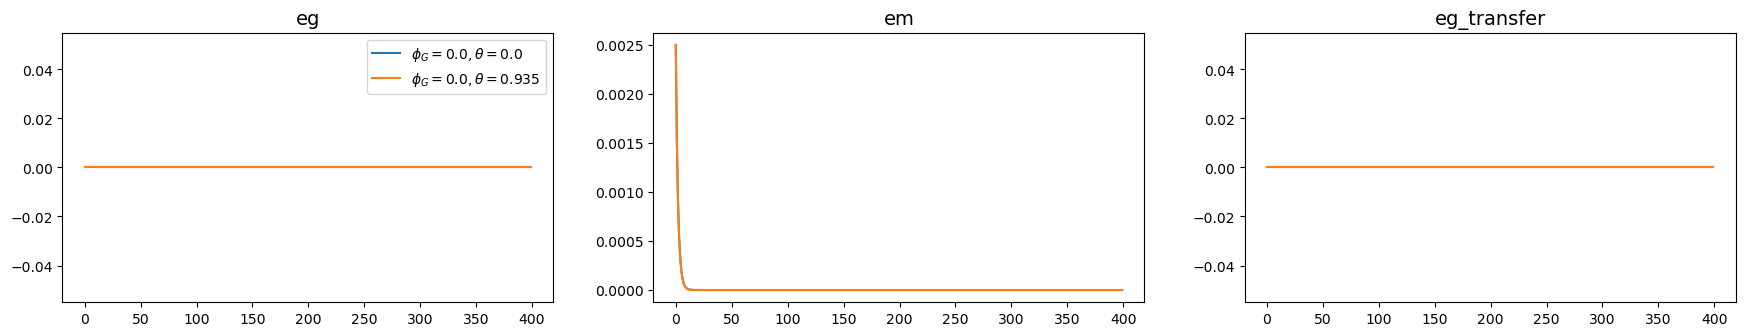


### varnames ###


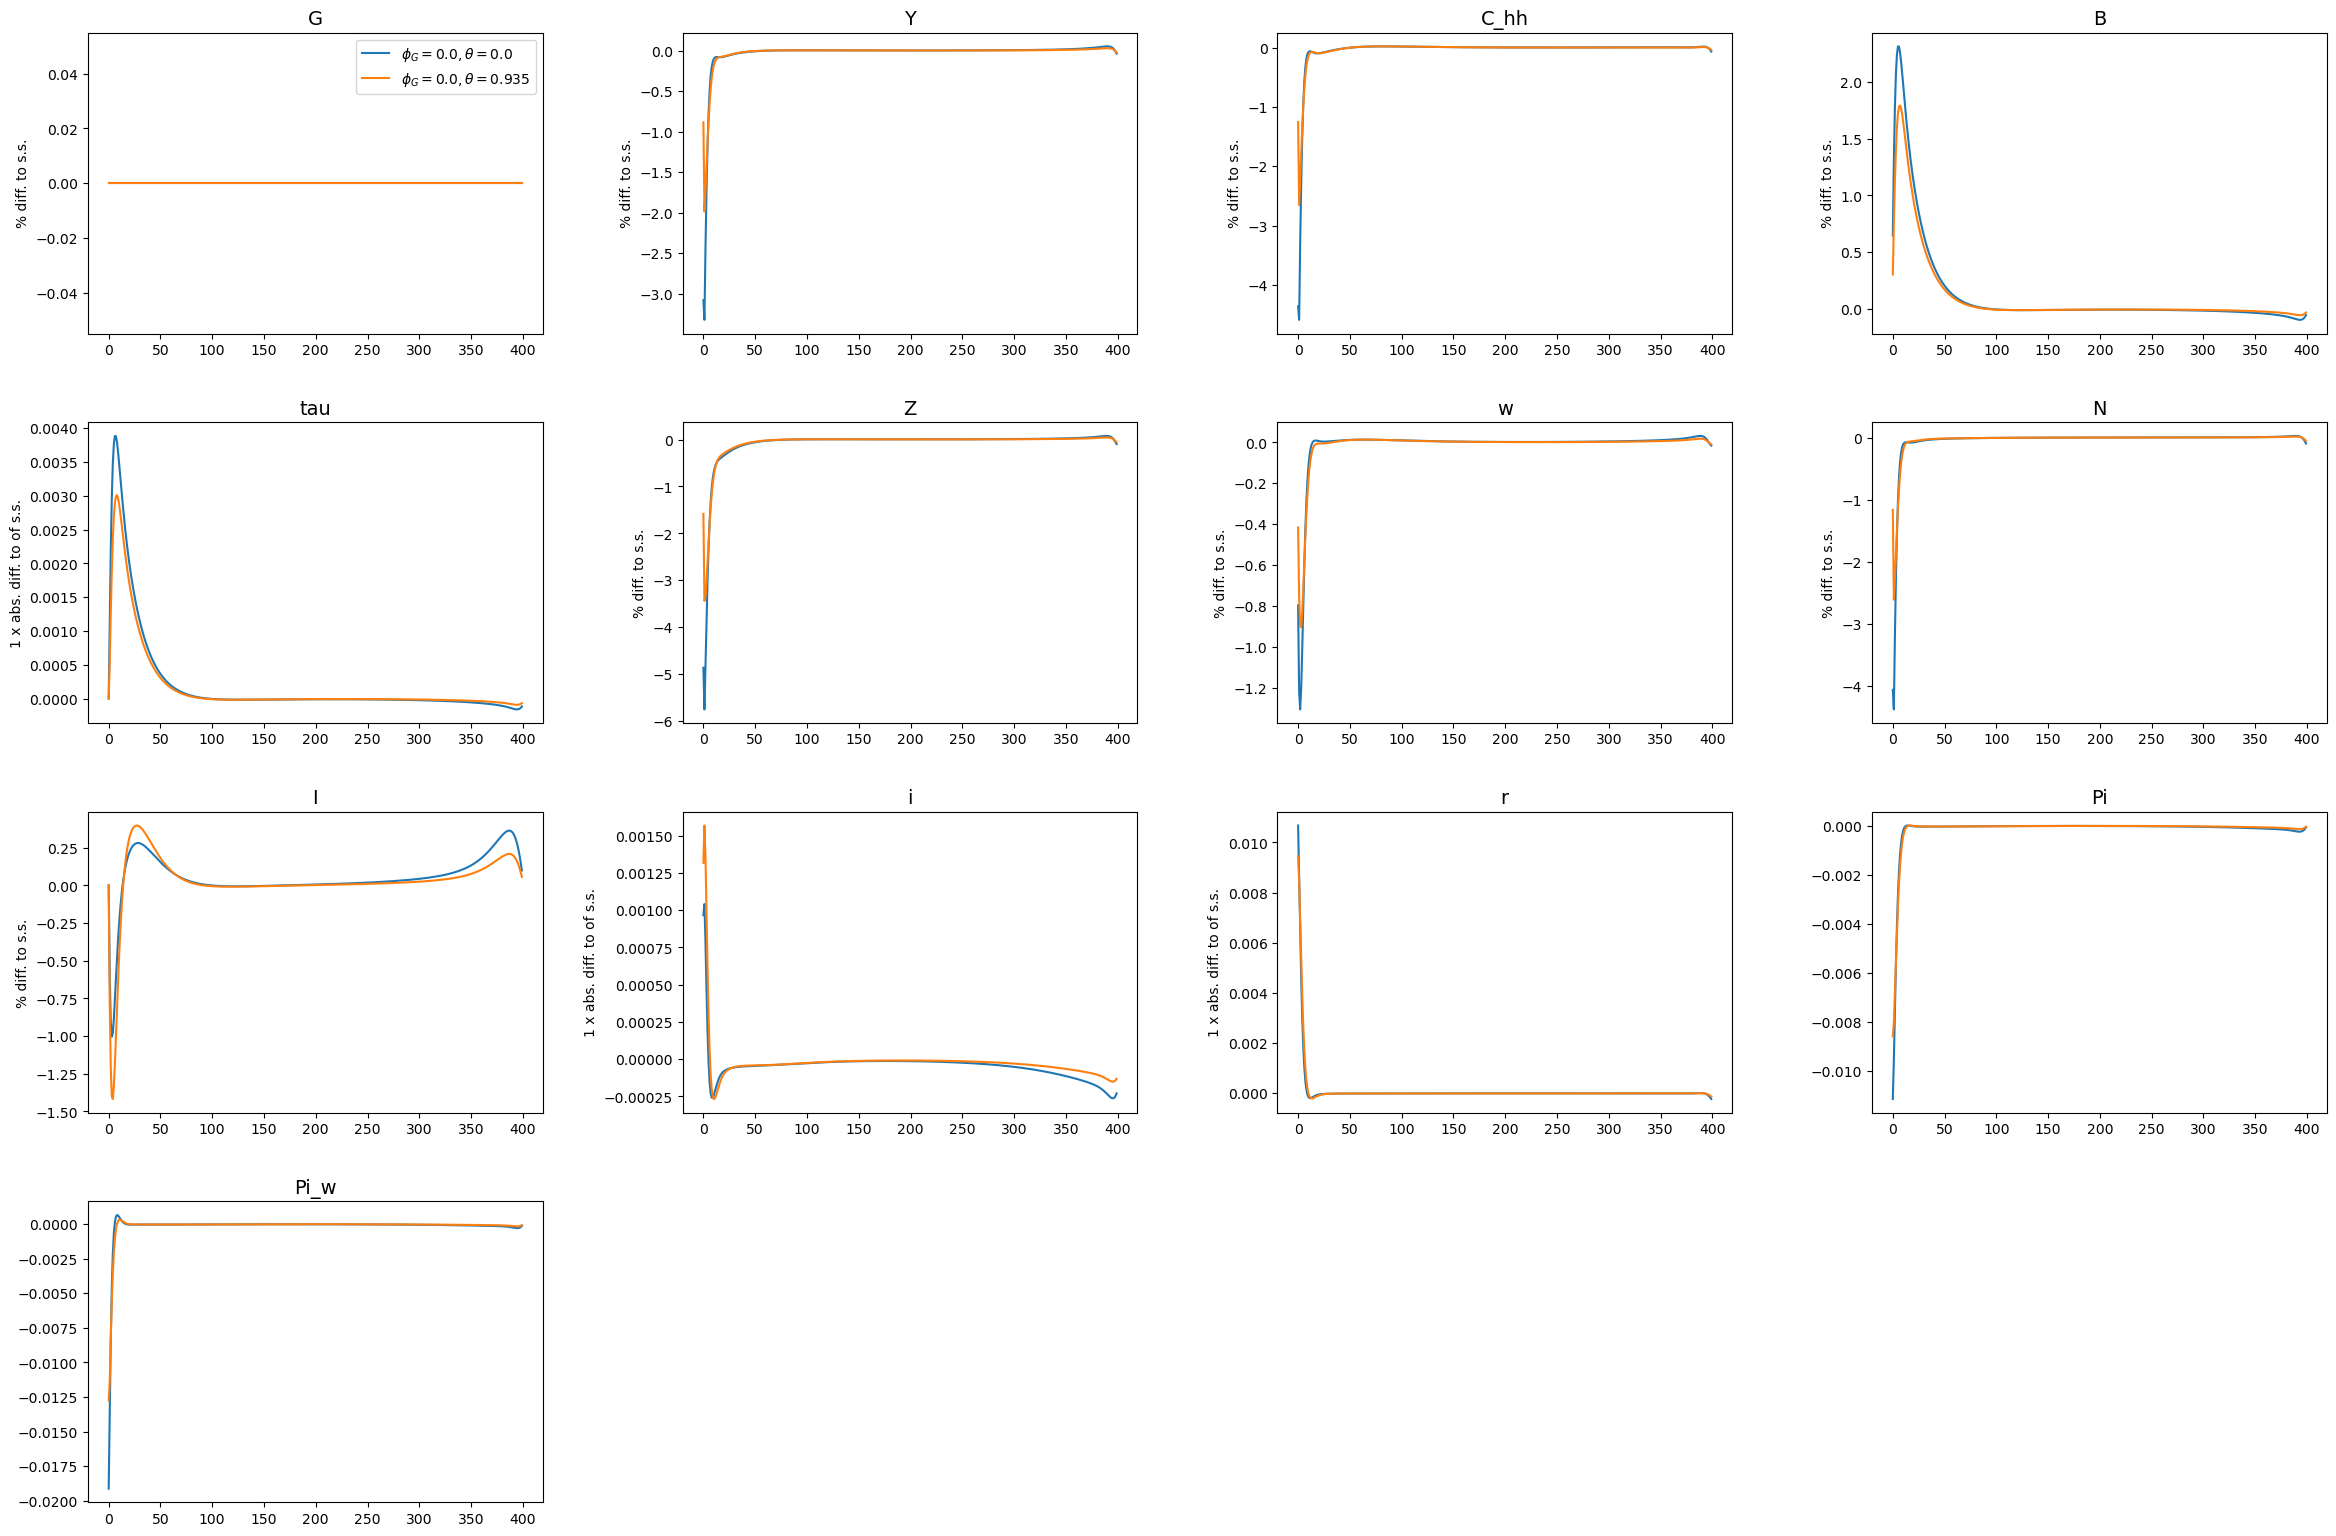

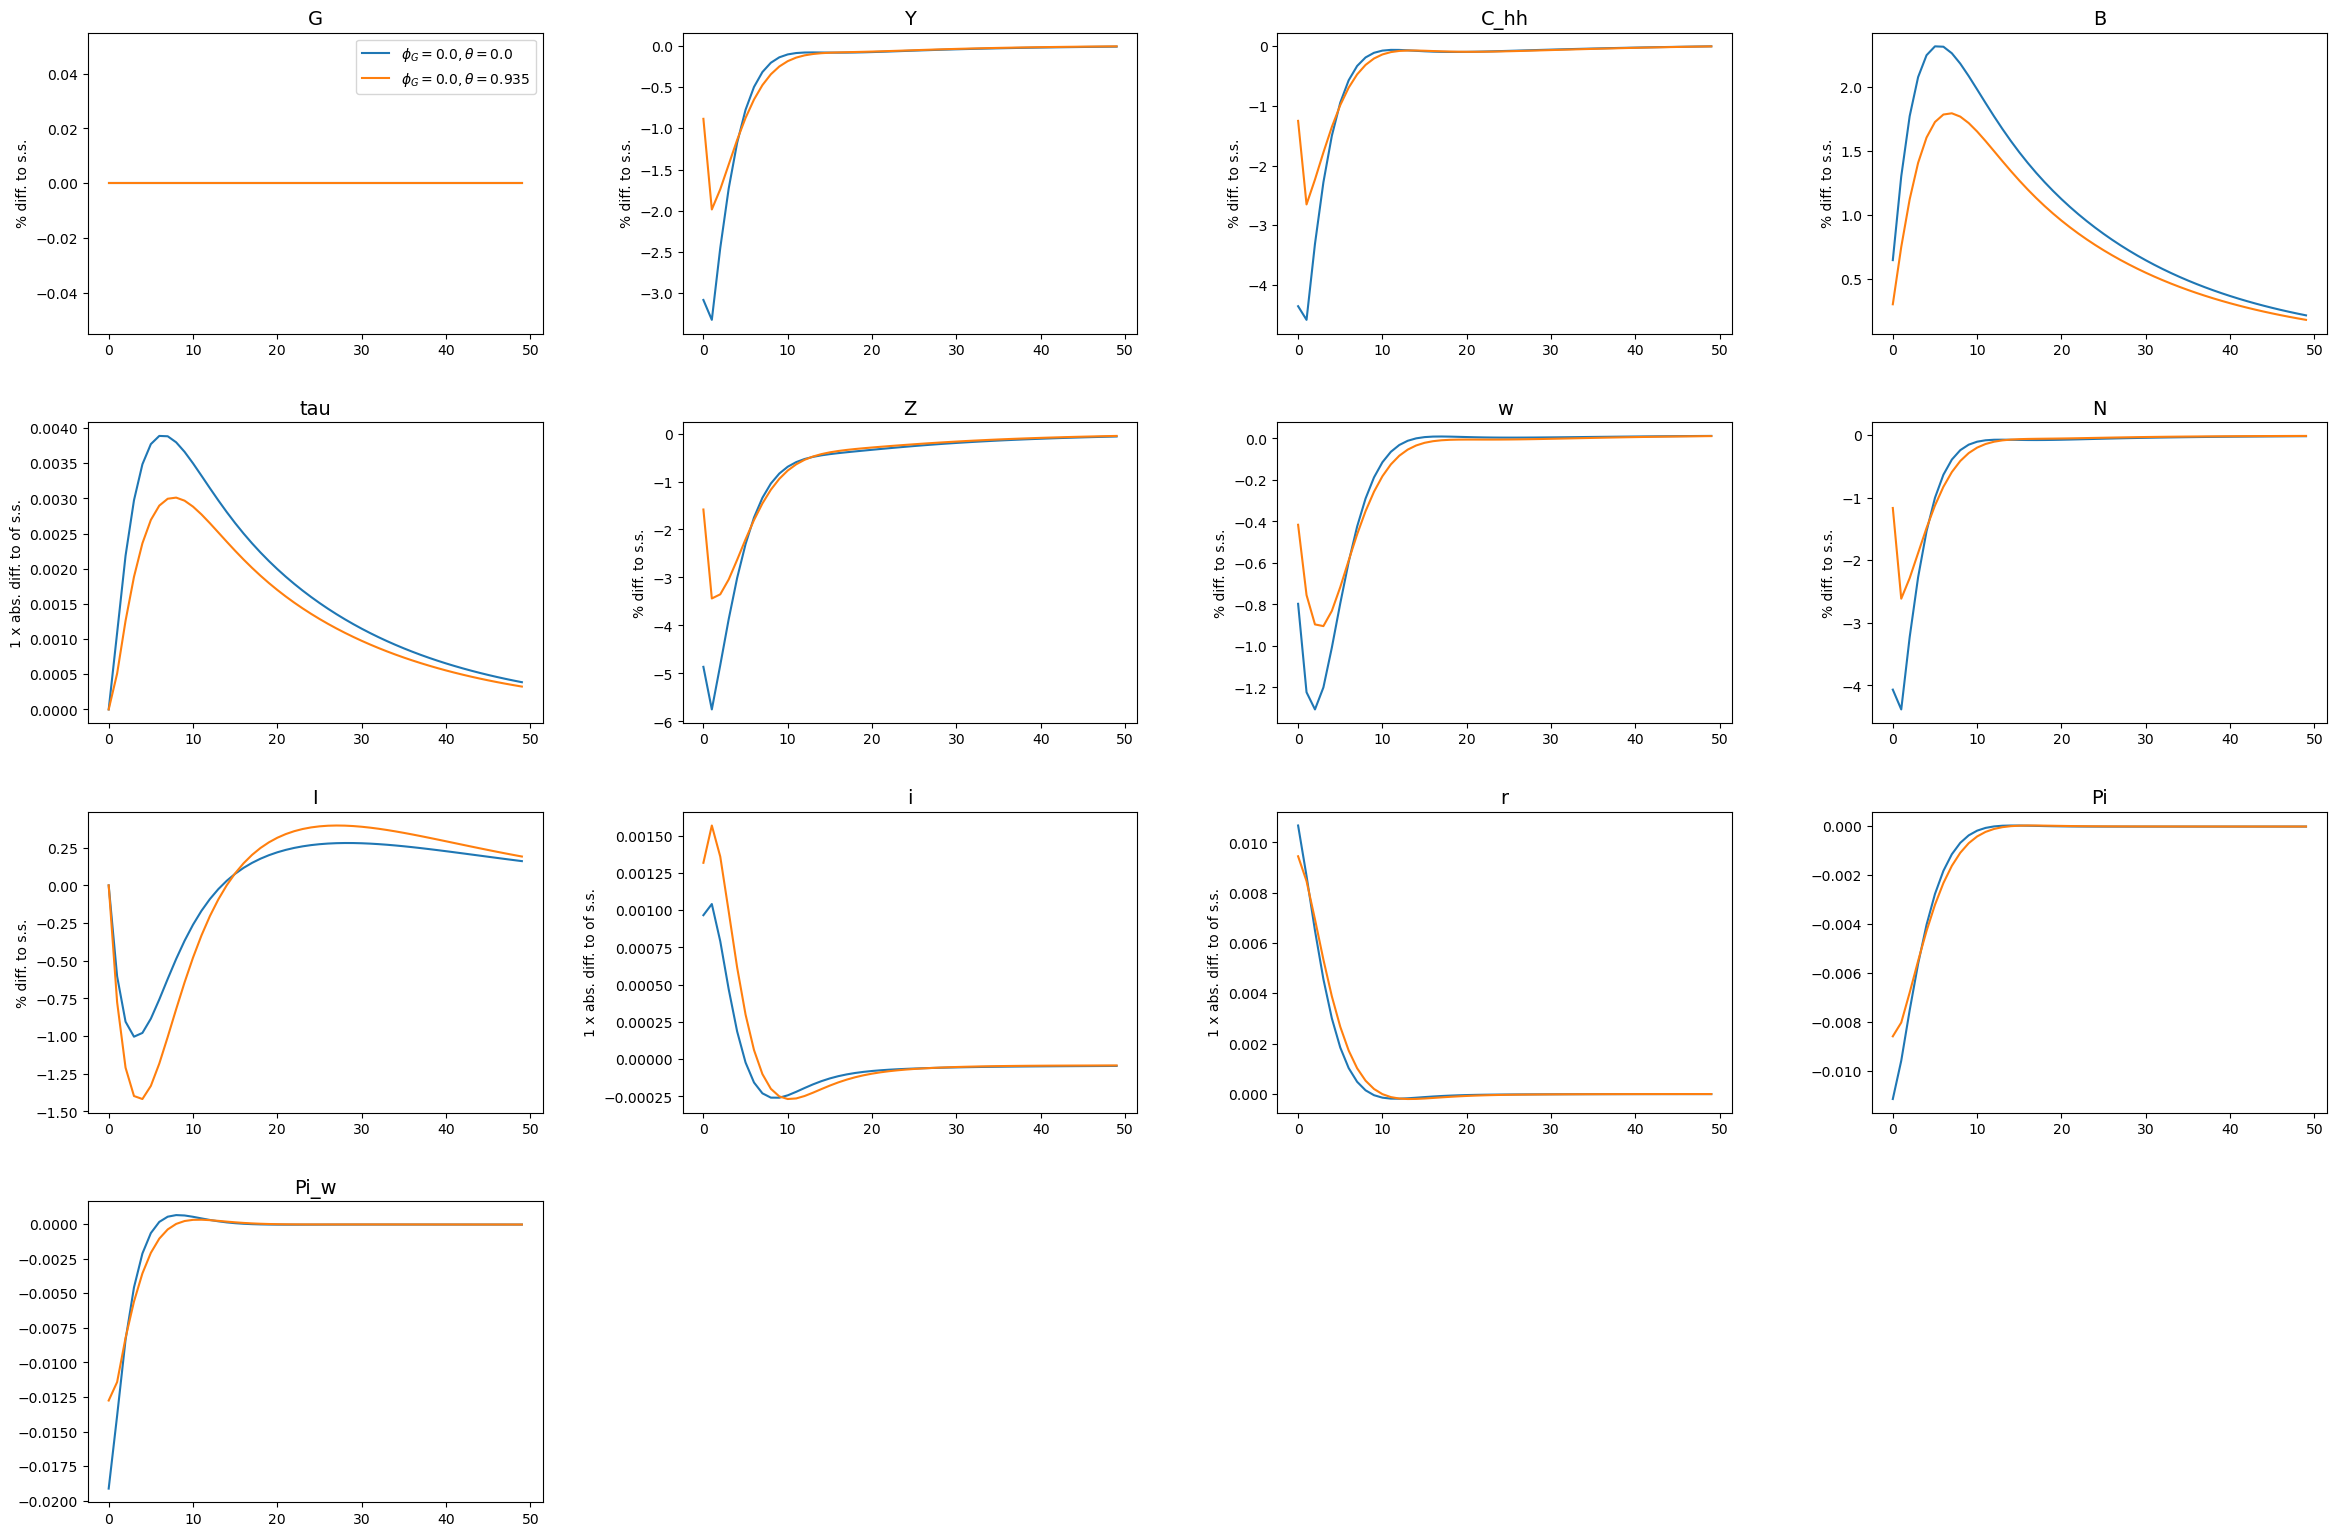

In [35]:
models = [model, model_sticky]
labels = [f'$\phi_G = {m.par.phi_G}, \\theta = {m.par.inattention}$' for m in models]
paths_short = ['G', 'Y', 'C_hh', 'B', 'tau', 'Z', 'w','N', 'I','i','r','Pi', 'Pi_w']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi', 'Pi_w']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra']
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=True)
model.compare_IRFs(models, labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff,  # facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False, do_shocks=False, T_max=50)

# Direct demand

In [46]:
model.jac[('Y', 'C_hh')]

KeyError: ('Y', 'C_hh')